In [ ]:
import pandas as pd

issues_df = pd.read_csv('issue_details.csv')

custom_fields_df = pd.read_csv('custom_fields.csv')

history_df = pd.read_csv('issues_history.csv')

In [ ]:
history_df

In [ ]:
issues_df = history_df

In [ ]:
issues_with_devs = issues_df[['issue_id', 'author_login']].drop_duplicates()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns



# Step 1: Filter for rows where added_type equals 'StateBundleElement'
filtered_df = issues_df[issues_df['added_type'] == 'StateBundleElement']

# Step 2: Sort by timestamp
filtered_df = filtered_df.sort_values(by='timestamp')

# Step 3 & 4: Identify the first transition to 'Review' and count subsequent transitions to 'To Do', 'Blocked', or 'In Progress'
def count_review_to_rework_transitions(df):
    review_started = False
    review_to_rework_count = 0
    
    for index, row in df.iterrows():
        if row['added_name'] == 'Review':
            review_started = True
        elif review_started and row['added_name'] in ['To Do', 'Blocked', 'In Progress']:
            review_to_rework_count += 1
        elif review_started and row['added_name'] in ['Done', 'Canceled']:
            review_started = False

    return review_to_rework_count

# Apply the function to each issue
transitions_count_by_issue = filtered_df.groupby('issue_id').apply(count_review_to_rework_transitions).reset_index(name='rework_count')

# Step 5: Merge the count with developers
transitions_count_with_devs = pd.merge(transitions_count_by_issue, issues_with_devs, on='issue_id')

# Step 6: Summarize by developer
dev_rework_summary = transitions_count_with_devs.groupby('author_login')['rework_count'].mean().reset_index()
dev_rework_summary.columns = ['author_login', 'average_rework_count']

# Sort by rework count in descending order
dev_rework_summary_sorted = dev_rework_summary.sort_values(by='average_rework_count', ascending=False)

# Display the developer rework summary
# tools.display_dataframe_to_user(name="Developer Rework Summary", dataframe=dev_rework_summary_sorted)

# Plotting the rework counts by developer
plt.figure(figsize=(12, 6))
sns.barplot(x='average_rework_count', y='author_login', data=dev_rework_summary_sorted, palette='viridis')
plt.title('Average Rework Count from Review to Other States by Developer')
plt.xlabel('Average Rework Count')
plt.ylabel('Developer')
plt.grid(True)
plt.show()

# Calculate and display quantiles
quantiles = dev_rework_summary_sorted['average_rework_count'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).reset_index()
quantiles.columns = ['Quantile', 'Average Rework Count']
# tools.display_dataframe_to_user(name="Rework Count Quantiles", dataframe=quantiles)

quantiles

In [ ]:
# Filter for comment activities
comment_activities = issues_df[issues_df['activity_type'] == 'CommentActivityItem']

# Count comments for each user
user_comment_activity = comment_activities.groupby('author_login').size().reset_index(name='comment_count')

# Sort by comment count in descending order
user_comment_activity_sorted = user_comment_activity.sort_values(by='comment_count', ascending=False)

# Display the user comment activity
user_comment_activity_sorted.head()

# Plotting user comment activity
plt.figure(figsize=(12, 6))
sns.barplot(x='comment_count', y='author_login', data=user_comment_activity_sorted, palette='viridis')
plt.title('User Comment Activity')
plt.xlabel('Number of Comments')
plt.ylabel('User')
plt.grid(True)
plt.show()

In [ ]:
# Filter for activities related to status changes
status_changes = issues_df[
    (issues_df['added_type'] == 'StateBundleElement') | 
    (issues_df['removed_type'] == 'StateBundleElement')
]

# Sort by issue_id and timestamp to get the sequence of changes for each issue
status_changes = status_changes.sort_values(by=['issue_id', 'timestamp'])


# Create a function to calculate time differences for relevant transitions
def calculate_review_times(df):
    df['next_timestamp'] = df['timestamp'].shift(-1)
    df['next_status'] = df['added_name'].shift(-1)
    df['duration'] = df['next_timestamp'] - df['timestamp']
    
    # Filter transitions that indicate a review period (e.g., In Progress, Blocked)
    review_transitions = df[
        ((df['added_name'] == 'In Progress') & (df['next_status'] != 'In Progress')) |
        ((df['added_name'] == 'Blocked') & (df['next_status'] != 'Blocked'))
    ]
    
    return review_transitions

# Apply the function to each issue
grouped = status_changes.groupby('issue_id').apply(calculate_review_times).reset_index(drop=True)

# Summarize the review times
review_summary = grouped.groupby('issue_id')['duration'].sum().reset_index()
review_summary['duration'] = review_summary['duration'].dt.total_seconds() / 3600  # Convert to hours

# Identify state transitions into and out of "Review"
review_transitions = status_changes[
    (status_changes['added_name'] == 'Review') | 
    (status_changes['removed_name'] == 'Review')
]

# Create a function to calculate the time spent in the "Review" state
def calculate_review_durations(df):
    df = df.sort_values(by='timestamp')
    df['next_timestamp'] = df['timestamp'].shift(-1)
    df['next_added_name'] = df['added_name'].shift(-1)
    df['next_removed_name'] = df['removed_name'].shift(-1)
    
    # Filter for transitions into "Review" and next transitions out of "Review"
    review_periods = df[
        (df['added_name'] == 'Review') & 
        (df['next_removed_name'] == 'Review')
    ]
    
    review_periods['duration'] = review_periods['next_timestamp'] - review_periods['timestamp']
    return review_periods

# Apply the function to each issue
grouped_review_durations = review_transitions.groupby('issue_id').apply(calculate_review_durations).reset_index(drop=True)

# Summarize the review times
review_durations_summary = grouped_review_durations.groupby('issue_id')['duration'].sum().reset_index()
review_durations_summary['duration'] = review_durations_summary['duration'].dt.total_seconds() / 3600  # Convert to hours

# Remove issues with zero duration for a more meaningful analysis
review_durations_summary_filtered = review_durations_summary[review_durations_summary['duration'] > 0]

# Plotting the distribution of review times
plt.figure(figsize=(10, 6))
plt.hist(review_durations_summary_filtered['duration'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Review Times')
plt.xlabel('Review Duration (hours)')
plt.ylabel('Number of Issues')
plt.grid(True)
plt.show()

# Plotting average review time per issue
avg_review_duration = review_durations_summary_filtered['duration'].mean()

plt.figure(figsize=(10, 6))
plt.barh(['Average Review Time'], [avg_review_duration], color='skyblue')
plt.title('Average Review Time per Issue')
plt.xlabel('Review Duration (hours)')
plt.grid(True, axis='x')
plt.show()

# Displaying the filtered review summary in a more human-readable format
review_durations_summary_filtered['duration'] = review_durations_summary_filtered['duration'].apply(lambda x: f'{x:.2f} hours')

import ace_tools as tools; tools.display_dataframe_to_user(name="Filtered Review Durations Summary", dataframe=review_durations_summary_filtered)

review_durations_summary_filtered.head()

In [ ]:
# Identify state transitions into and out of "Review"
review_transitions = status_changes[
    (status_changes['added_name'] == 'Review') | 
    (status_changes['removed_name'] == 'Review')
]

# Create a function to calculate the time spent in the "Review" state
def calculate_review_durations(df):
    df = df.sort_values(by='timestamp')
    df['next_timestamp'] = df['timestamp'].shift(-1)
    df['next_added_name'] = df['added_name'].shift(-1)
    df['next_removed_name'] = df['removed_name'].shift(-1)
    
    # Filter for transitions into "Review" and next transitions out of "Review"
    review_periods = df[
        (df['added_name'] == 'Review') & 
        (df['next_removed_name'] == 'Review')
    ]
    
    review_periods['duration'] = review_periods['next_timestamp'] - review_periods['timestamp']
    return review_periods

# Apply the function to each issue
grouped_review_durations = review_transitions.groupby('issue_id').apply(calculate_review_durations).reset_index(drop=True)

# Summarize the review times
review_durations_summary = grouped_review_durations.groupby('issue_id')['duration'].sum().reset_index()
review_durations_summary['duration'] = review_durations_summary['duration'].dt.total_seconds() / 3600  # Convert to hours

# Remove issues with zero duration for a more meaningful analysis
review_durations_summary_filtered = review_durations_summary[review_durations_summary['duration'] > 0]

# Plotting the distribution of review times
plt.figure(figsize=(10, 6))
plt.hist(review_durations_summary_filtered['duration'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Review Times')
plt.xlabel('Review Duration (hours)')
plt.ylabel('Number of Issues')
plt.grid(True)
plt.show()

# Plotting average review time per issue
avg_review_duration = review_durations_summary_filtered['duration'].mean()

plt.figure(figsize=(10, 6))
plt.barh(['Average Review Time'], [avg_review_duration], color='skyblue')
plt.title('Average Review Time per Issue')
plt.xlabel('Review Duration (hours)')
plt.grid(True, axis='x')
plt.show()

# Displaying the filtered review summary in a more human-readable format
review_durations_summary_filtered['duration'] = review_durations_summary_filtered['duration'].apply(lambda x: f'{x:.2f} hours')

import ace_tools as tools; tools.display_dataframe_to_user(name="Filtered Review Durations Summary", dataframe=review_durations_summary_filtered)

review_durations_summary_filtered.head()

In [ ]:
import scipy.stats as stats
import seaborn as sns

# Descriptive Statistics
mean_duration = review_durations_summary_filtered['duration'].mean()
std_duration = review_durations_summary_filtered['duration'].std()
skewness = review_durations_summary_filtered['duration'].skew()
kurtosis = review_durations_summary_filtered['duration'].kurtosis()

descriptive_stats = {
    "Mean": mean_duration,
    "Standard Deviation": std_duration,
    "Skewness": skewness,
    "Kurtosis": kurtosis
}

# Plot Histogram and KDE
plt.figure(figsize=(10, 6))
sns.histplot(review_durations_summary_filtered['duration'], bins=30, kde=True, stat="density", linewidth=0)
plt.title('Histogram and KDE of Review Durations')
plt.xlabel('Review Duration (hours)')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Distribution Fitting
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Histogram
sns.histplot(review_durations_summary_filtered['duration'], bins=30, kde=False, stat="density", linewidth=0, ax=ax)

# Fit different distributions and plot
dist_names = ['norm', 'expon', 'lognorm']
for dist_name in dist_names:
    dist = getattr(stats, dist_name)
    param = dist.fit(review_durations_summary_filtered['duration'])
    pdf_fitted = dist.pdf(np.linspace(min(review_durations_summary_filtered['duration']), max(review_durations_summary_filtered['duration']), 100), *param)
    ax.plot(np.linspace(min(review_durations_summary_filtered['duration']), max(review_durations_summary_filtered['duration']), 100), pdf_fitted, label=f'{dist_name} fit')

ax.set_title('Review Durations Distribution Fitting')
ax.set_xlabel('Review Duration (hours)')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True)
plt.show()

# Display descriptive statistics
import ace_tools as tools; tools.display_dataframe_to_user(name="Descriptive Statistics", dataframe=pd.DataFrame(descriptive_stats, index=[0]))

descriptive_stats

# Read Files

In [147]:
import pandas as pd
import glob
import json

In [148]:
issue_history = {}

for file in glob.glob('./datasets/issue_history_*.json'):
    with open(file, 'r') as f:
        data = json.load(f)
    issue_history.update(data)

issue_links = {}

for file in glob.glob('./datasets/issue_links_*.json'):
    with open(file, 'r') as f:
        data = json.load(f)
        issue_links.update(data)


issues_info = []

for file in glob.glob('./datasets/issues_info_*.json'):
    with open(file, 'r') as f:
        data = json.load(f)
    issues_info += data

In [149]:
import itertools

def get_first_n_items(d, n):
    return dict(itertools.islice(d.items(), n))

In [ ]:
get_first_n_items(issue_links, 3)

In [150]:
# Function to extract and expand records
def expand_records(issue_id, activities):
    records = []
    for activity in activities:
        base_record = {
            'issue_id': issue_id,
            'timestamp': activity['timestamp'],
            'author_login': activity['author']['login'],
            'author_name': activity['author']['name'],
            'activity_type': activity['$type']
        }

        # Expand added items
        if isinstance(activity.get('added'), list):
            for added_item in activity['added']:
                record = base_record.copy()
                record.update({
                    'added_type': added_item.get('$type'),
                    'added_name': added_item.get('name'),
                    'removed_type': None,
                    'removed_name': None,
                })
                records.append(record)
        elif isinstance(activity.get('added'), int):
            record = base_record.copy()
            record.update({
                'added_type': 'int',
                'added_name': activity['added'],
                'removed_type': None,
                'removed_name': None,
            })
            records.append(record)
        elif activity.get('added') is None:
            record = base_record.copy()
            record.update({
                'added_type': 'NoneType',
                'added_name': None,
                'removed_type': None,
                'removed_name': None,
            })
            records.append(record)

        # Expand removed items
        if isinstance(activity.get('removed'), list):
            for removed_item in activity['removed']:
                record = base_record.copy()
                record.update({
                    'removed_type': removed_item.get('$type'),
                    'removed_name': removed_item.get('name'),
                    'added_type': None,
                    'added_name': None,
                })
                records.append(record)
        elif isinstance(activity.get('removed'), int):
            record = base_record.copy()
            record.update({
                'removed_type': 'int',
                'removed_name': activity['removed'],
                'added_type': None,
                'added_name': None,
            })
            records.append(record)
        elif activity.get('removed') is None:
            record = base_record.copy()
            record.update({
                'removed_type': 'NoneType',
                'removed_name': None,
                'added_type': None,
                'added_name': None,
            })
            records.append(record)

        # If no added or removed, add the base record
        if not activity.get('added') and not activity.get('removed'):
            record = base_record.copy()
            record.update({
                'added_type': None,
                'added_name': None,
                'removed_type': None,
                'removed_name': None,
            })
            records.append(record)
    return records

# Convert the data to a list of dictionaries suitable for a DataFrame
all_records = []
for issue_id, activities in issue_history.items():
    all_records.extend(expand_records(issue_id, activities))

# Create the DataFrame
history_df = pd.DataFrame(all_records)
history_df = history_df.drop_duplicates(subset=['issue_id', 'timestamp'])

In [151]:
import hashlib


issue_details = []

for data in issues_info:
    # Extract main issue details
    issue_details.append({
        'issue_id': data['id'],
        'idReadable': data['idReadable'],
        'updated': data['updated'],
        'resolved': data['resolved'],
        'reporter_login': data['reporter']['login'],
        'reporter_fullName': data['reporter']['fullName'],
        'reporter_id': data['reporter']['id'],
        'created': data['created'],
        'summary': data['summary'],
        'description': data['description'],
    })

custom_fields = []

for issue in issues_info:
    data = issue
    for field in data['customFields']:
        field_name = field['projectCustomField']['field']['name']
        field_value = field.get('value', {})
        if isinstance(field_value, dict):
            for sub_key, sub_value in field_value.items():
                custom_fields.append({
                    'issue_id': issue['id'],
                    'field_name': field_name,
                    'attribute': sub_key,
                    'value': sub_value
                })
        else:
            custom_fields.append({
                'issue_id': issue['id'],
                'field_name': field_name,
                'attribute': 'value',
                'value': field_value
            })

# Convert to DataFrames
details_df = pd.DataFrame(issue_details)
fields_df = pd.DataFrame(custom_fields)

details_df = details_df.drop_duplicates(subset=['issue_id', 'updated'])


def calculate_hash(row):
    row_string = ''.join(row.values.astype(str))
    return hashlib.md5(row_string.encode()).hexdigest()

fields_df['hash'] = fields_df[['issue_id', 'field_name', 'attribute']].apply(calculate_hash, axis=1)
fields_df = fields_df.drop_duplicates(subset=['hash']).drop(columns=['hash'])

In [ ]:
# fields_df.drop_duplicates(subset=['issue_id', 'field_name', 'attribute'])

fields_df

In [ ]:
df_cleaned[(fields_df['issue_id'] == '92-1424125') & (fields_df['field_name'] == 'Type')]

In [152]:
def json_to_dataframe(json_data):
    records = []
    for key, issue_links in json_data.items():
        for issue_link in issue_links:
            try:
                link_type = issue_link['linkType']
                for issue in issue_link['issues']:
                    record = {
                        "main_id": key,
                        "sourceToTarget": link_type['sourceToTarget'],
                        "targetToSource": link_type['targetToSource'],
                        "name": link_type['name'],
                        "issue_idReadable": issue['idReadable'],
                        "issue_summary": issue['summary'],
                        "issue_id": issue['id']
                    }
                    records.append(record)
                if not issue_link['issues']:
                    record = {
                        "main_id": key,
                        "sourceToTarget": link_type['sourceToTarget'],
                        "targetToSource": link_type['targetToSource'],
                        "name": link_type['name'],
                        "issue_idReadable": None,
                        "issue_summary": None,
                        "issue_id": None
                    }
                    records.append(record)
            except:
                print(key)
                raise
    return pd.DataFrame(records)

# Convert the JSON data to a DataFrame
links_df = json_to_dataframe(issue_links)

In [8]:
history_df

details_df

fields_df

links_df

,issue_id,field_name,attribute,value
0,92-1424125,Type,localizedName,None
1,92-1424125,Type,color,"{'id': '0', '$type': 'FieldStyle'}"
2,92-1424125,Type,name,Task
3,92-1424125,Type,id,53-3712
4,92-1424125,Type,$type,EnumBundleElement
...,...,...,...,...
1127979,92-669573,Environments,$type,EnumBundleElement
1127980,92-669573,Services,value,[]
1127981,92-669573,Start Date,value,None
1127982,92-669573,Due Date,value,None


In [ ]:
df[(df['main_id'] == '92-1424115') & ~(df['issue_idReadable'].isna())]

In [ ]:
len(nested_ids)

In [ ]:
nested_ids += list(df[(df['main_id'].isin(nested_ids))]['issue_id'].unique())

In [ ]:
nested_df = df[(df['main_id'].isin(nested_ids))]

In [ ]:
nested_ids = list(df[(df['main_id'] == '92-770926')]['issue_id'].unique())

nested_ids.append('92-770926')

In [ ]:
details_df[details_df['idReadable'] == 'VR-4118']

In [ ]:
df.to_csv('links.csv')

In [ ]:
df['name'].unique()

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
import json

data = links_df

def build_relationship_tree_bfs(data, core_issue):
    # Initialize the graph
    G = nx.DiGraph()
    
    # Initialize a queue with the core issue
    queue = deque([core_issue])
    
    # Set to keep track of visited nodes to avoid processing them again
    visited = set()
    
    # Process the queue iteratively
    while queue:
        current_issue = queue.popleft()
        if current_issue in visited:
            continue
        
        visited.add(current_issue)
        child_issues = data[data['main_id'] == current_issue]
        
        for _, row in child_issues.iterrows():
            source = row['main_id']
            target = row['issue_id']
            relationship = row['sourceToTarget'] if pd.notna(row['sourceToTarget']) else row['targetToSource']
            
            if pd.isna(row['issue_idReadable']):
                continue
            
            G.add_node(source, label=f"{source}\n(Epic)")
            G.add_node(target, label=row['issue_idReadable'])
            G.add_edge(source, target, label=relationship)
            
            # Add the child issue to the queue if it's also a parent and not visited yet
            if target in data['main_id'].values and target not in visited:
                queue.append(target)
    
    return G


core_issue = '92-770926'
relationship_tree_bfs = build_relationship_tree_bfs(data, core_issue)

# Convert the graph to a JSON-like structure
def graph_to_json(G):
    tree = {}
    for node in G.nodes:
        tree[node] = {
            "label": G.nodes[node]['label'],
            "children": [{"id": target, "relationship": G.edges[node, target]['label']} for target in G.successors(node)]
        }
    return tree

relationship_tree_json = graph_to_json(relationship_tree_bfs)
relationship_tree_json_str = json.dumps(relationship_tree_json, indent=4)

# Print JSON structure
print(relationship_tree_json_str)

# Draw the graph
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(relationship_tree_bfs)  # positions for all nodes
nx.draw(relationship_tree_bfs, pos, with_labels=True, labels=nx.get_node_attributes(relationship_tree_bfs, 'label'), node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', arrows=True)
nx.draw_networkx_edge_labels(relationship_tree_bfs, pos, edge_labels=nx.get_edge_attributes(relationship_tree_bfs, 'label'))

plt.title(f'Relationship Tree for Issue Epic {core_issue} (Any Depth)')
plt.show()

In [ ]:
links_df[(links_df['main_id'] == '92-770926') & ~(links_df['issue_id'].isna())]

In [ ]:
links_df[(links_df['main_id'] == '92-985686') & ~(links_df['issue_id'].isna())]

In [ ]:
epics = fields_df[(fields_df['field_name'] == 'Type') & (fields_df['value'] == 'Epic')]['issue_id'].unique()

In [ ]:
details_df[details_df['issue_id'].isin(epics)].iloc[100::]

In [ ]:
links_df[(links_df['main_id'].isin(epics)) & ~(links_df['issue_id'].isna())].iloc[::100]

In [ ]:
import pandas as pd
from collections import deque, defaultdict
import json

# Load the provided CSV file
# file_path = './expl_links.csv'
df = links_df

# Remove invalid relationships (i.e., where issue_id or issue_summary is NaN)
df_filtered = df.dropna(subset=['issue_id', 'issue_summary'])

# Rebuild the relationship map with the filtered data
relationship_map_filtered = defaultdict(list)
for _, row in df_filtered.iterrows():
    relationship_map_filtered[row['main_id']].append((row['issue_id'], row['issue_summary'], row['name']))

def build_tree_iterative_refined(root_id, relationship_map):
    tree = {}
    visited = set()
    queue = deque([(root_id, tree)])

    while queue:
        current_id, current_tree = queue.popleft()
        if current_id in visited:
            continue
        visited.add(current_id)

        children = relationship_map.get(current_id, [])
        for child_id, child_summary, child_type in children:
            if child_id not in visited:
                current_tree[f"{child_type} {child_id}: {child_summary}"] = {}
                queue.append((child_id, current_tree[f"{child_type} {child_id}: {child_summary}"]))

    return tree

def get_issue_ids(tree):
    issue_ids = set()

    def recurse(subtree):
        for key in subtree.keys():
            issue_id = key.split(' ')[1].strip(':')
            issue_ids.add(issue_id)
            recurse(subtree[key])

    recurse(tree)
    return list(issue_ids)

# Build the tree starting from the epic
epic_id = '92-770926'
epic_id = '92-673039'
tree_iterative_refined = build_tree_iterative_refined(epic_id, relationship_map_filtered)

# Display the refined tree structure
tree_structure_iterative_refined = json.dumps(tree_iterative_refined, indent=2, ensure_ascii=False)
print(tree_structure_iterative_refined)

In [ ]:
# Build the tree starting from the epic
epic_id = '92-673039'
tree_iterative_refined = build_tree_iterative_refined(epic_id, relationship_map_filtered)

# Convert the tree to PlantUML mindmap format
epic_summary = df_filtered[df_filtered['main_id'] == epic_id]['issue_summary'].values[0] if not df_filtered[df_filtered['main_id'] == epic_id]['issue_summary'].empty else epic_id
puml_mindmap = tree_to_puml(tree_iterative_refined, epic_summary)

# Output the PlantUML mindmap

with open('./adr/mindmap_v2.puml', 'w') as f:
    f.write(puml_mindmap)
# print(puml_mindmap)

In [ ]:
get_issue_ids(tree_iterative_refined)

In [ ]:
tree_iterative_refined

In [153]:
import pandas as pd
from collections import deque, defaultdict
import json


def build_tree_iterative_refined(root_id, relationship_map):
    tree = {}
    visited = set()
    queue = deque([(root_id, tree)])

    while queue:
        current_id, current_tree = queue.popleft()
        if current_id in visited:
            continue
        visited.add(current_id)

        children = relationship_map.get(current_id, [])
        for child_id, child_summary, child_type in children:
            if child_id not in visited:
                current_tree[child_id] = {'summary': child_summary, 'children': {}}
                queue.append((child_id, current_tree[child_id]['children']))

    return tree

def tree_to_puml(tree, root_label):
    puml = "@startmindmap\n"
    puml += f"* {root_label}\n"

    def recurse(subtree, level):
        nonlocal puml
        indent = "  " * level
        for key, value in subtree.items():
            summary = value['summary'] if value['summary'] else key
            puml += f"{indent}* {summary}\n"
            recurse(value['children'], level + 1)

    recurse(tree, 1)
    puml += "@endmindmap"
    return puml

def get_issue_ids(tree):
    issue_ids = set()

    def recurse(subtree):
        for key in subtree.keys():
            issue_ids.add(key)
            recurse(subtree[key]['children'])

    recurse(tree)
    return list(issue_ids)

In [ ]:
# Remove invalid relationships (i.e., where issue_id or issue_summary is NaN)
df_filtered = df.dropna(subset=['issue_id', 'issue_summary'])

# Define the relationship types we want to include
selected_relationship_types = ['subtask of']

# Rebuild the relationship map with the filtered data and selected relationship types
relationship_map_filtered = defaultdict(list)
for _, row in df_filtered.iterrows():
    if row['targetToSource'] in selected_relationship_types:
        relationship_map_filtered[row['main_id']].append((row['issue_id'], row['issue_summary'], row['name']))
        

# Build the tree starting from the epic
epic_id = '92-770926'
epic_id = '92-898886'
tree_iterative_refined = build_tree_iterative_refined(epic_id, relationship_map_filtered)

# Get the summary for the epic, fallback to epic_id if not available
epic_summary = df_filtered[df_filtered['main_id'] == epic_id]['issue_summary'].values[0] if not df_filtered[df_filtered['main_id'] == epic_id]['issue_summary'].empty else epic_id

# Convert the tree to PlantUML mindmap format
puml_mindmap = tree_to_puml(tree_iterative_refined, epic_summary)

# Output the PlantUML mindmap
print(puml_mindmap)

# Get the array of issue IDs
issue_ids = get_issue_ids(tree_iterative_refined)

# Output the array of issue IDs
print(issue_ids)

In [ ]:
tasks_ids = fields_df[(fields_df['issue_id'].isin(issue_ids)) \
    & (fields_df['field_name'] == 'Type') & (fields_df['value'] == 'Task')]['issue_id'].unique()

In [ ]:
tasks_ids[:10]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
# file_path = '/mnt/data/issues_history.csv'

reviewer = 'Кудрявцев Роман Викторович'
# reviewer = 'Вансевич Евгений Алексеевич'
reviewer = 'Чаплинский Ярослав Эдуардович'
# reviewer = 'Салтанов Станислав Геннадьевич'


tasks_ids = merged_df[merged_df['reviewer'] == reviewer]['issue_id'].unique()

issues_df = history_df[history_df['issue_id'].isin(tasks_ids)]



# Ensure timestamps are in datetime format
issues_df['timestamp'] = pd.to_datetime(issues_df['timestamp'], unit='ms')

# Filter for rows where added_type equals 'StateBundleElement'
filtered_df = issues_df[issues_df['added_type'] == 'StateBundleElement']

# Sort by timestamp
filtered_df = filtered_df.sort_values(by='timestamp')

# Calculate the durations for review periods
def calculate_review_durations(df):
    durations = []
    review_start = None
    
    for index, row in df.iterrows():
        if row['added_name'] == 'Review':
            review_start = row['timestamp']
        elif review_start and row['added_name'] in ['To Do', 'Blocked', 'In Progress']:
            durations.append((row['timestamp'] - review_start).total_seconds() / 3600)
            review_start = None
        elif review_start and row['added_name'] in ['Done', 'Canceled']:
            review_start = None
    
    return durations

# Apply the function to each issue
review_durations = []
grouped = filtered_df.groupby('issue_id')
for name, group in grouped:
    review_durations.extend(calculate_review_durations(group))

# Convert durations to DataFrame
review_durations_df = pd.DataFrame(review_durations, columns=['review_duration_hours'])

# Plot Histogram and KDE
plt.figure(figsize=(12, 6))
sns.histplot(review_durations_df['review_duration_hours'], bins=30, kde=True, stat="density", linewidth=0, color='blue', alpha=0.6)
plt.title('Histogram and KDE of Review Durations')
plt.xlabel('Review Duration (hours)')
plt.ylabel('Density')
plt.grid(True)
plt.show()

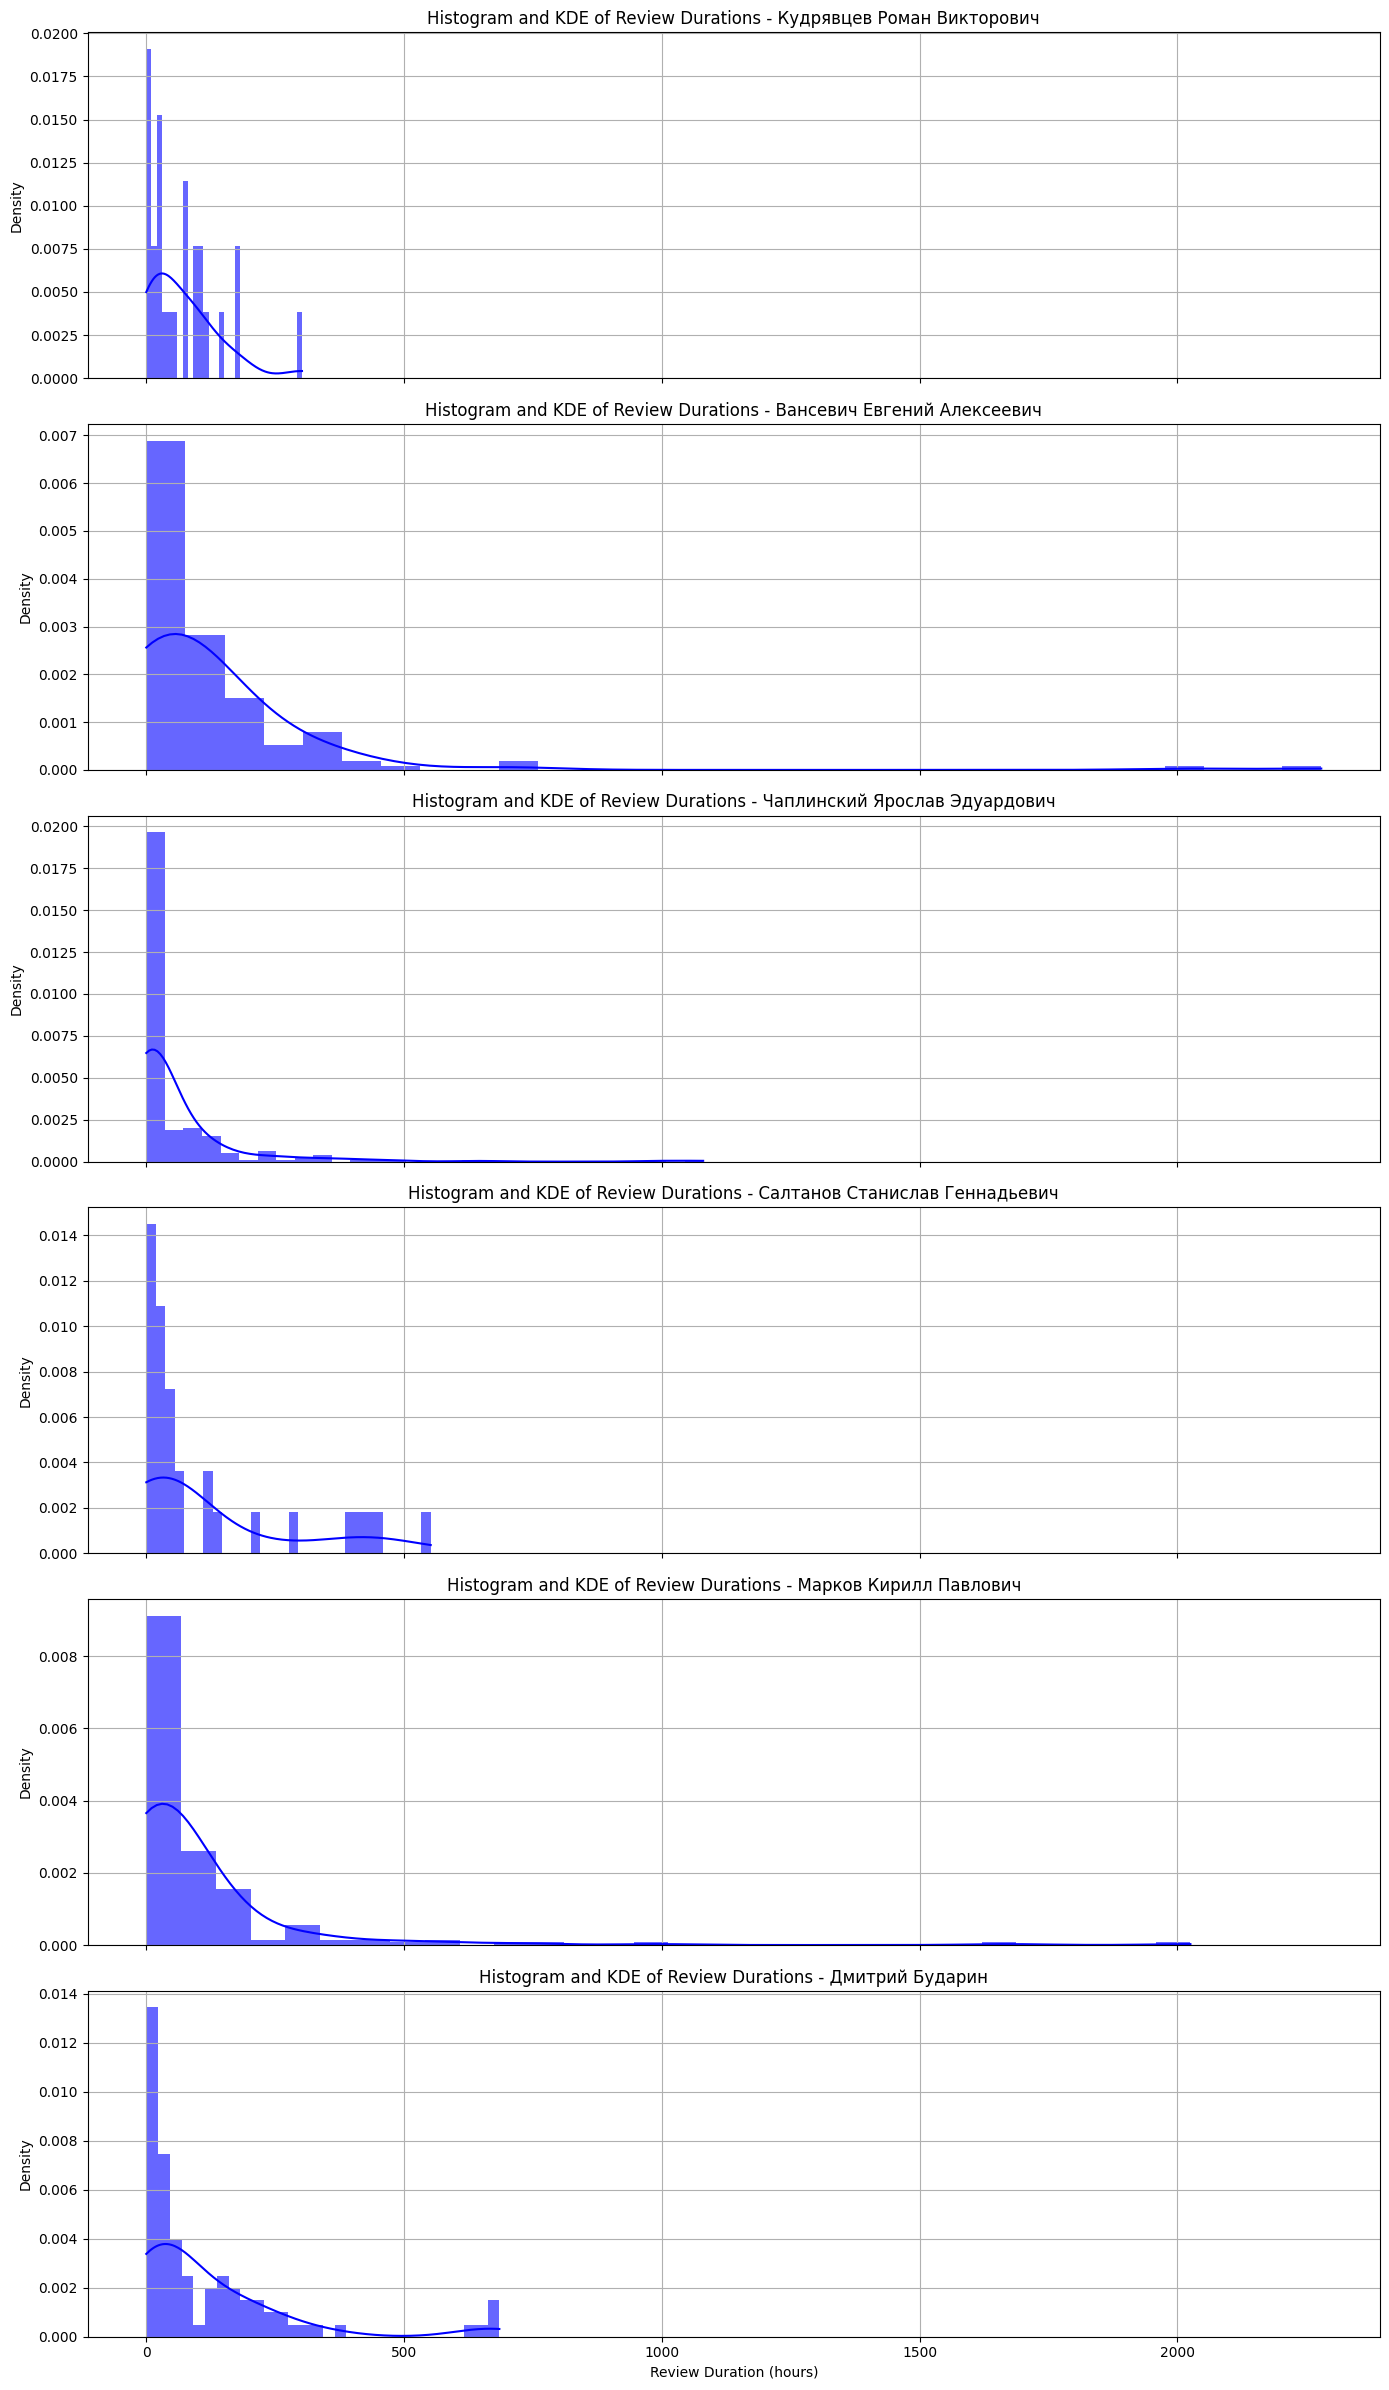

In [195]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
# file_path = '/mnt/data/issues_history.csv'
# merged_df = pd.read_csv('path_to_merged_df.csv')  # Ensure merged_df is loaded
# history_df = pd.read_csv('path_to_history_df.csv')  # Ensure history_df is loaded

reviewers = [
    'Кудрявцев Роман Викторович',
    'Вансевич Евгений Алексеевич',
    'Чаплинский Ярослав Эдуардович',
    'Салтанов Станислав Геннадьевич',
    'Марков Кирилл Павлович',
    'Дмитрий Бударин'
]

# Ensure timestamps are in datetime format
history_df['timestamp'] = pd.to_datetime(history_df['timestamp'], unit='ms')

# Filter for rows where added_type equals 'StateBundleElement'
filtered_df = history_df[history_df['added_type'] == 'StateBundleElement']

# Sort by timestamp
filtered_df = filtered_df.sort_values(by='timestamp')

def calculate_review_durations(df):
    durations = []
    review_start = None
    
    for index, row in df.iterrows():
        if row['added_name'] == 'Review':
            review_start = row['timestamp']
        elif review_start and row['added_name'] in ['To Do', 'Blocked', 'In Progress']:
            durations.append((row['timestamp'] - review_start).total_seconds() / 3600)
            review_start = None
        elif review_start and row['added_name'] in ['Done', 'Canceled']:
            review_start = None
    
    return durations

all_review_durations = []

for reviewer in reviewers:
    tasks_ids = merged_df[merged_df['reviewer'] == reviewer]['issue_id'].unique()
    issues_df = filtered_df[filtered_df['issue_id'].isin(tasks_ids)]
    
    review_durations = []
    grouped = issues_df.groupby('issue_id')
    for name, group in grouped:
        review_durations.extend(calculate_review_durations(group))
    
    review_durations_df = pd.DataFrame(review_durations, columns=['review_duration_hours'])
    review_durations_df['reviewer'] = reviewer
    all_review_durations.append(review_durations_df)

all_review_durations_df = pd.concat(all_review_durations)

# Plotting the data
fig, axes = plt.subplots(len(reviewers), 1, figsize=(14, len(reviewers) * 4), sharex=True)

for ax, reviewer in zip(axes, reviewers):
    sns.histplot(
        data=all_review_durations_df[all_review_durations_df['reviewer'] == reviewer],
        x='review_duration_hours',
        kde=True,
        bins=30,
        stat="density",
        linewidth=0,
        color='blue',
        alpha=0.6,
        ax=ax
    )
    ax.set_title(f'Histogram and KDE of Review Durations - {reviewer}')
    ax.set_xlabel('Review Duration (hours)')
    ax.set_ylabel('Density')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
details_df.dtypes

In [ ]:
fields_df[fields_df['field_name'] == 'Type']


In [10]:
def merge_details_with_fields(details_df, fields_df):

    # Filter fields_df to only include rows where attribute is 'name'
    filtered_fields_df = fields_df[fields_df['attribute'] == 'name']
    
    # Drop the attribute column as it's no longer needed
    filtered_fields_df = filtered_fields_df.drop(columns=['attribute'])
    
    # Pivot the filtered DataFrame to get the desired structure
    pivot_df = filtered_fields_df.pivot(index='issue_id', columns='field_name', values='value').reset_index()
    
    # Merge the pivoted DataFrame with details_df
    merged_df = details_df.merge(pivot_df, on='issue_id', how='left')
    
    # Rename the columns as required
    merged_df.rename(columns={
        'Type': 'type',
        'Assignee': 'assignee',
        'Reviewer [HR]': 'reviewer',
        'Priority': 'priority',
        'State': 'state'
    }, inplace=True)

    return merged_df

In [ ]:
 merged_df[(merged_df['state'] == 'Done') & (merged_df['type'] == 'Epic')].iloc[300::]

In [ ]:
 merged_df[(merged_df['state'] == 'Done') & (merged_df['type'] == 'Task')]['assignee'].unique()

In [ ]:
fields_df[(fields_df['field_name'] == 'Assignee') & (fields_df['attribute'] == 'login')]['value'].unique()

In [ ]:
infra = ['Valentin_Marchuk', 'grigorev.mark', 'Vitaliy_Guselnikov', 'krupenko.ilya', 'aleksandrov.e23', 'mustafetov.n', 'nevskiy.vilyam']

issue_ids = fields_df[fields_df['value'].isin(infra)]['issue_id'].unique()

In [ ]:
['summary'].unique()[:100]

In [ ]:
import datetime as dt


merged_df['created'] = pd.to_datetime(merged_df['created'], unit='ms')

# Get current date
current_date = pd.to_datetime(dt.datetime.now())

# Calculate start of this month and start of last month
start_of_current_month = current_date.replace(day=1)
start_of_last_month = (start_of_current_month - pd.DateOffset(months=1)).replace(day=1)

# Filter tasks created in the previous month and this month
filtered_tasks = merged_df[
    (merged_df['created'] >= start_of_last_month) & 
    (merged_df['created'] < start_of_current_month + pd.DateOffset(months=1))
]

guselnikov_tasks = filtered_tasks[filtered_tasks['reporter_login'] == 'Vitaliy_Guselnikov']


guselnikov_tasks_str = ''
for _, row in guselnikov_tasks.iterrows():
    if row['description']:
        guselnikov_tasks_str += f'#{row['idReadable']}' + row['summary'] + '\n'
        guselnikov_tasks_str += row['description'] + '\n'

print(guselnikov_tasks_str)

In [188]:
with open('./datasets/guselnikov.md', 'w') as f:
    f.write(guselnikov_tasks_str)

In [ ]:
merged_df[(merged_df['issue_id'].isin(issue_ids)) & (merged_df['type'] == 'Task')]

In [ ]:
filtered_df = merged_df[(merged_df['issue_id'].isin(issue_ids)) & (merged_df['type'] == 'Task')]

# Group by assignee and order by date, returning first 20 tasks for each group
grouped_df = filtered_df.sort_values(by='updated').groupby('reporter_fullName').head(20)

# Pretty format output
pretty_output = ""

for name, group in grouped_df.groupby('reporter_fullName'):
    pretty_output += f"\n{name}\n\n"
    for _, row in group.iterrows():
        pretty_output += f"{row['idReadable']} {row['summary']}\n"

print(pretty_output)

In [ ]:
fields_df

In [ ]:
details_df

In [193]:
cron = merged_df[(merged_df['idReadable'].str.contains('DO')) & (merged_df['summary'].str.contains('cron'))]

for _, row in cron.iterrows():
    print(f'{row['summary'])
    print(row['description'])

Написать доку по cron
В HRTech стоит задача автоматизации регулярного выполнения различных типов задач. Написать доку, как это работает
Добавить поддержку запуска задач по cron


В HRTech стоит задача автоматизации регулярного выполнения различных типов задач. Вот описание трёх основных категорий:

1. **Обновление materialized views** в базе данных: у нас имеется
   около 20 таких представлений, и необходимо их обновлять каждый час. Время
   обновления может варьироваться в зависимости от конкретного представления.

2. **Вычислительные задачи**, такие как расчёт заработной платы, которые
   запускаются ежедневно и выполняются в автоматическом режиме.

3. **Задачи по синхронизации данных**, которые предусматривают регулярное
   обращение к внешним сервисам с интервалом в 20 минут для сбора и обработки
   информации.

На данный момент мы используем отдельные сервисы на стороне сервера написанные на golang для каждой категории задач.

Однако мы стремимся переориентировать все эти сервисы 

In [ ]:
./changelog-builder.go --gitlab-user ${GITLAB_USER} --gitlab-passwrd ... --gtilab-repo ${GITLAB_REPO} 

In [ ]:
1. Cron job запускает скрипт раз в 20 минут
2. Если хэш появился
3. Парсишь ютрек
4. Делаешь ветку и МР на добавление изменений в файл AutoChangelog

Скрипт должен принимать:

- креды гита
- репозиторий в котором мы проверяем
- креды ютрека
- неймспейс

Требования:
- сделать только для стейджа аутха
- запсускать раз в 20 минут

## AuthV3 analytics

In [51]:
import pandas as pd

# Set display option to show all columns
pd.set_option('display.max_columns', None)

In [154]:
merged_df = merge_details_with_fields(details_df, fields_df)

In [27]:
authv3_id = 'VR-4118'

yt_id = details_df[details_df['idReadable'] == authv3_id].iloc[0]['issue_id']

In [ ]:
merged_df

In [ ]:
merged_df

In [18]:
# Remove invalid relationships (i.e., where issue_id or issue_summary is NaN)
links_filtered = links_df.dropna(subset=['issue_id', 'issue_summary'])

# Define the relationship types we want to include
selected_relationship_types = ['subtask of']

# Rebuild the relationship map with the filtered data and selected relationship types
relationship_map_filtered = defaultdict(list)
for _, row in links_filtered.iterrows():
    if row['targetToSource'] in selected_relationship_types:
        relationship_map_filtered[row['main_id']].append((row['issue_id'], row['issue_summary'], row['name']))

In [31]:

tree_iterative_refined = build_tree_iterative_refined(yt_id, relationship_map_filtered)

# Get the summary for the epic, fallback to epic_id if not available
epic_summary = links_filtered[links_filtered['main_id'] == yt_id]['issue_summary'].values[0] if not links_filtered[links_filtered['main_id'] == yt_id]['issue_summary'].empty else yt_id

# Convert the tree to PlantUML mindmap format
puml_mindmap = tree_to_puml(tree_iterative_refined, epic_summary)

# Output the PlantUML mindmap
# print(puml_mindmap)

# Get the array of issue IDs
authv3_issues_ids = get_issue_ids(tree_iterative_refined)

# Output the array of issue IDs
# print(issue_ids)

In [30]:
len(issue_ids)

196

In [155]:
auth_details_df = merged_df[merged_df['issue_id'].isin(authv3_issues_ids)]

auth_history_df = history_df[history_df['issue_id'].isin(authv3_issues_ids)]

auth_fields_df = fields_df[fields_df['issue_id'].isin(authv3_issues_ids)]

In [37]:
auth_details_df.to_csv('./datasets/authv3/auth_details.csv')

auth_history_df.to_csv('./datasets/authv3/auth_history.csv')

auth_fields_df.to_csv('./datasets/authv3/auth_fields.csv')

In [206]:
empl_df = pd.read_json('./datasets/employees.json')

In [183]:
merged_df.to_csv('./datasets/details.csv')

history_df.to_csv('./datasets/history.csv')

fields_df.to_csv('./datasets/fields.csv')

In [44]:
print(auth_details_df.dtypes)

issue_id              object
idReadable            object
updated                int64
resolved             float64
reporter_login        object
reporter_fullName     object
reporter_id           object
created                int64
summary               object
description           object
assignee              object
Complexity            object
Devs                  object
Environments          object
Impact                object
Importance            object
priority              object
Product               object
reviewer              object
Services              object
state                 object
Status                object
Stream                object
type                  object
Urgency               object
dtype: object


In [56]:
auth_fields_df[auth_fields_df['field_name'] == 'Project']

auth_fields_df['field_name'].unique()

array(['Type', 'Devs', 'Assignee', 'Reviewer [HR]', 'Priority',
       'Complexity', 'Estimation', 'State', 'Stream', 'Time Spent',
       'Product', 'Environments', 'Services', 'Start Date', 'Due Date',
       'Days in Review', 'Status', 'Fixed in build',
       'Total number of test cases', 'Number of failed test cases',
       'Number of passed test cases'], dtype=object)

In [156]:
auth_details_df

,issue_id,idReadable,updated,resolved,reporter_login,reporter_fullName,reporter_id,created,summary,description,assignee,Complexity,Devs,Environments,Impact,Importance,priority,Product,reviewer,Services,state,Status,Stream,type,Urgency
0,92-1424125,VR-11149,1717697342816,NaN,Valentin_Marchuk,Марчук Валентин,24-5060,1717697342816,[FE] Собирать метрики фейлов авторизации AuthV3,Нам нужно собирать метрики:\n\n\n\n* сколько л...,Лавриненко Василий Александрович,Семечки,FE,local,NaN,NaN,Show-stopper,NaN,Марчук Валентин,NaN,To Do,NaN,Product,Task,NaN
1,92-1424115,VR-11148,1717697343237,NaN,Valentin_Marchuk,Марчук Валентин,24-5060,1717696705992,[UserStory] AuthV3 авторизация. Сбор событий и...,## Проблема\n\nЕсли у человека нету активной м...,Марчук Валентин,Вроде не изян,NaN,local,NaN,NaN,Critical,NaN,NaN,NaN,In Progress,NaN,Support,User Story,NaN
228,92-1393585,VR-10905,1716985371341,1.716985e+12,zyuvanov.sergey,Зюванов Сергей Игоревич,24-6045,1716897681148,[BUG] Не подтягивается количество сотрудников ...,# Общее описание\n\nОкружение: `prod`\nУчётна...,Марков Кирилл Павлович,Семечки,BE,prod,NaN,NaN,Critical,NaN,Марков Кирилл Павлович,NaN,Done,NaN,Support,Bug,NaN
477,92-1371814,VR-10652,1716281526657,1.716281e+12,grigorev.mark,Григорьев Марк,24-4984,1716281485432,[BE] обновить Toolkit версию на стейдже,обновить Toolkit версию на стейдже до 0.0.24\n...,Григорьев Марк,NaN,BE,stage,NaN,NaN,Normal,NaN,Вансевич Евгений Алексеевич,NaN,Canceled,NaN,Product,Task,NaN
478,92-1371665,VR-10651,1716452673672,1.716453e+12,Valentin_Marchuk,Марчук Валентин,24-5060,1716280356715,[BE] Подготовить МРы для выкатки AuthV3 в прод,"Подготовить МРы для выкатки AuthV3 в прод, мры...",Вансевич Евгений Алексеевич,Семечки,BE,stage,NaN,NaN,Critical,NaN,Вансевич Евгений Алексеевич,NaN,Done,NaN,Product,Task,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21450,92-884020,VR-5413,1714721140487,1.711460e+12,Yaraslau_Chaplinski,Чаплинский Ярослав Эдуардович,24-3942,1695099249164,[BE] - AuthV3 - Интеграция auth v3 в adminka-api,# Проблема\n\nОбъявлено об обязательном перехо...,Чаплинский Ярослав Эдуардович,Вроде не изян,BE,local,NaN,NaN,Show-stopper,NaN,Шогин Михаил Михайлович,NaN,Canceled,NaN,Product,Task,NaN
21451,92-884019,VR-5412,1714993118775,1.708380e+12,Yaraslau_Chaplinski,Чаплинский Ярослав Эдуардович,24-3942,1695099208523,[BE] - AuthV3 - Написать middleware для аутент...,# Проблема\n\nОбъявлено об обязательном перехо...,Чаплинский Ярослав Эдуардович,Вроде не изян,BE,local,NaN,NaN,Show-stopper,NaN,Шогин Михаил Михайлович,NaN,Canceled,NaN,Product,Task,NaN
21452,92-884017,VR-5411,1714721500572,NaN,Yaraslau_Chaplinski,Чаплинский Ярослав Эдуардович,24-3942,1695099098425,[BE] - AuthV3 - Написать клиент для работы с a...,# Проблема\n\nОбъявлено об обязательном перехо...,Чаплинский Ярослав Эдуардович,Вроде не изян,BE,local,NaN,NaN,Show-stopper,NaN,Вансевич Евгений Алексеевич,NaN,Review,NaN,Product,Task,NaN
21488,92-878245,VR-5371,1714993132926,1.701123e+12,Yaraslau_Chaplinski,Чаплинский Ярослав Эдуардович,24-3942,1694671614211,[BE][ARCH] - AuthV3 - Архитектура и Декомпозиция,# Проблема\n\nОбъявлено об обязательном перехо...,Шогин Михаил Михайлович,Вроде не изян,BE,local,NaN,NaN,Show-stopper,NaN,Шогин Михаил Михайлович,NaN,Done,NaN,Product,Task,NaN


### Графики

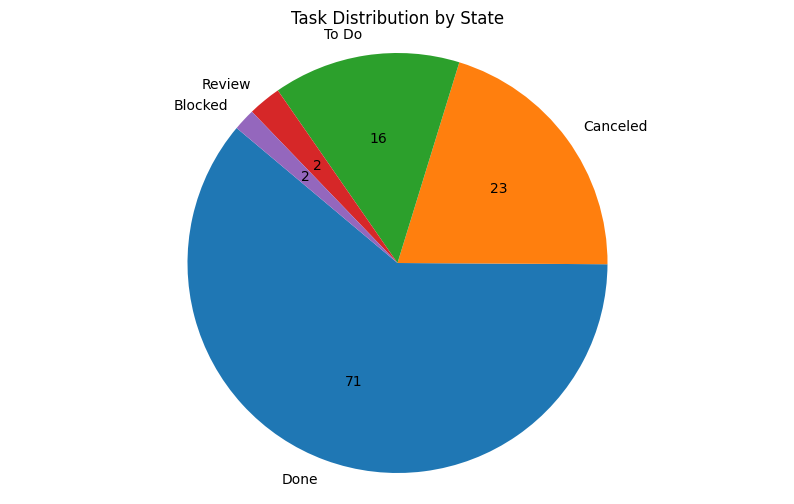

In [174]:
import pandas as pd
import matplotlib.pyplot as plt


# Extract relevant columns
task_data = auth_details_df[(auth_details_df['idReadable'].str.contains('VR-')) & (auth_details_df['type'] == 'Task')][['issue_id', 'summary', 'state', 'type']]

# Drop rows with missing state information
task_data = task_data.dropna(subset=['state'])

# Count the number of tasks in each state
state_counts = task_data['state'].value_counts()

# Create a pie chart with numbers instead of percentages
plt.figure(figsize=(10, 6))
plt.pie(state_counts, labels=state_counts.index, autopct=lambda p: f'{int(p * sum(state_counts) / 100)}', startangle=140)
plt.title('Task Distribution by State')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Path to save the plot
# pie_chart_with_numbers_path = '/path/to/save/task_state_distribution_numbers.png'  # Update with your desired save path
# plt.savefig(pie_chart_with_numbers_path)

# Display the plot
plt.show()

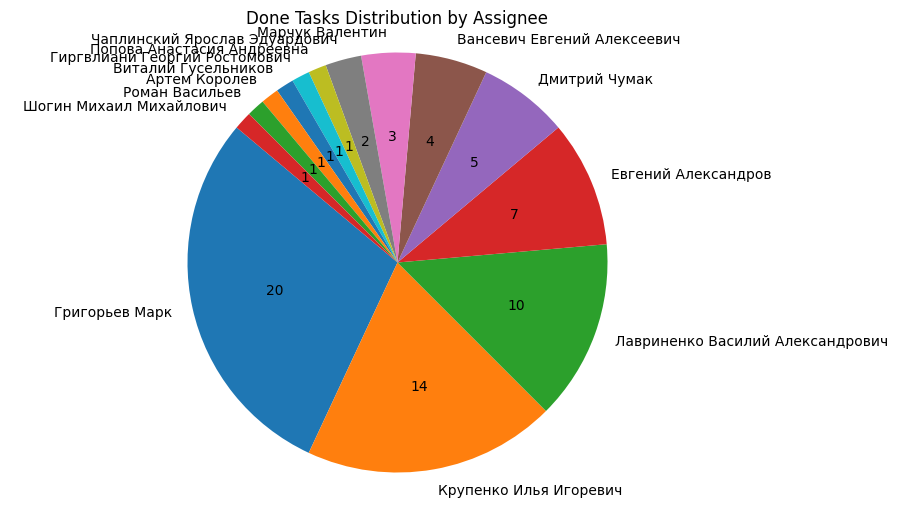

In [159]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file

vr_tasks = auth_details_df[auth_details_df['idReadable'].str.contains('VR-')]

# Extract relevant columns and filter for 'Done' state
done_tasks = vr_tasks[(vr_tasks['state'] == 'Done') & (vr_tasks['type'] == 'Task')]
assignee_counts = done_tasks['assignee'].value_counts()

# Create a pie chart for 'Done' tasks grouped by assignee
plt.figure(figsize=(10, 6))
plt.pie(assignee_counts, labels=assignee_counts.index, autopct=lambda p: f'{int(p * sum(assignee_counts) / 100)}', startangle=140)
plt.title('Done Tasks Distribution by Assignee')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# # Path to save the plot
# done_tasks_pie_chart_path = '/mnt/data/done_tasks_distribution_by_assignee.png'  # Update with your desired save path
# plt.savefig(done_tasks_pie_chart_path)

# Display the plot
plt.show()


In [64]:
auth_history_df['author_name'].unique(), auth_history_df['activity_type'].unique()

(array(['Лавриненко Василий Александрович', 'YouTrack Workflow',
        'Шогин Михаил Михайлович', 'JetBrains YouTrack',
        'Ливенцев Сергей Викторович', 'Марчук Валентин', 'Григорьев Марк',
        'Вансевич Евгений Алексеевич', 'GitLab',
        'Крестенкова Виктория Александровна', 'Артем Аниковский',
        'Крупенко Илья Игоревич', 'Попова Анастасия Андреевна',
        'Диана Ливенцева', 'Евгений Александров', 'Виталий Гусельников',
        'Чаплинский Ярослав Эдуардович', 'Знаткова Мария Михайловна',
        'Эрик Садгалин', 'Дмитрий Чумак', 'Марков Кирилл Павлович',
        'Харапут Роман Сергеевич', 'София  Захарова',
        'Кудрявцев Роман Викторович', 'Артем Королев',
        'Зюванов Сергей Игоревич', 'Гиргвлиани Георгий Ростомович',
        'Владимир Стороженко', 'Роман Васильев', 'Дмитрий Бударин',
        'Deleted User'], dtype=object),
 array(['CustomFieldActivityItem', 'CommentActivityItem'], dtype=object))

In [65]:
auth_history_df

,issue_id,timestamp,author_login,author_name,activity_type,added_type,added_name,removed_type,removed_name
165,92-985686,1701155774153,Lavrinenko.V2,Лавриненко Василий Александрович,CustomFieldActivityItem,User,Шогин Михаил Михайлович,None,None
167,92-985686,1701158417867,workflow_user_1224751877,YouTrack Workflow,CustomFieldActivityItem,int,60,None,None
169,92-985686,1701162021070,workflow_user_1224751877,YouTrack Workflow,CustomFieldActivityItem,int,120,None,None
171,92-985686,1701169215075,workflow_user_1224751877,YouTrack Workflow,CustomFieldActivityItem,int,180,None,None
173,92-985686,1701172813501,workflow_user_1224751877,YouTrack Workflow,CustomFieldActivityItem,int,240,None,None
...,...,...,...,...,...,...,...,...,...
868195,92-814502,1702627207437,workflow_user_1224751877,YouTrack Workflow,CustomFieldActivityItem,int,63660,None,None
868197,92-814502,1702627207860,workflow_user_1224751877,YouTrack Workflow,CustomFieldActivityItem,int,63720,None,None
868199,92-814502,1702627212559,workflow_user_1224751877,YouTrack Workflow,CustomFieldActivityItem,int,63780,None,None
868201,92-814502,1702630808920,workflow_user_1224751877,YouTrack Workflow,CustomFieldActivityItem,int,63840,None,None


/var/folders/x2/0f74_mmn0ts5qbnsn_wp241w0000gn/T/ipykernel_7973/3440574282.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/x2/0f74_mmn0ts5qbnsn_wp241w0000gn/T/ipykernel_7973/3440574282.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



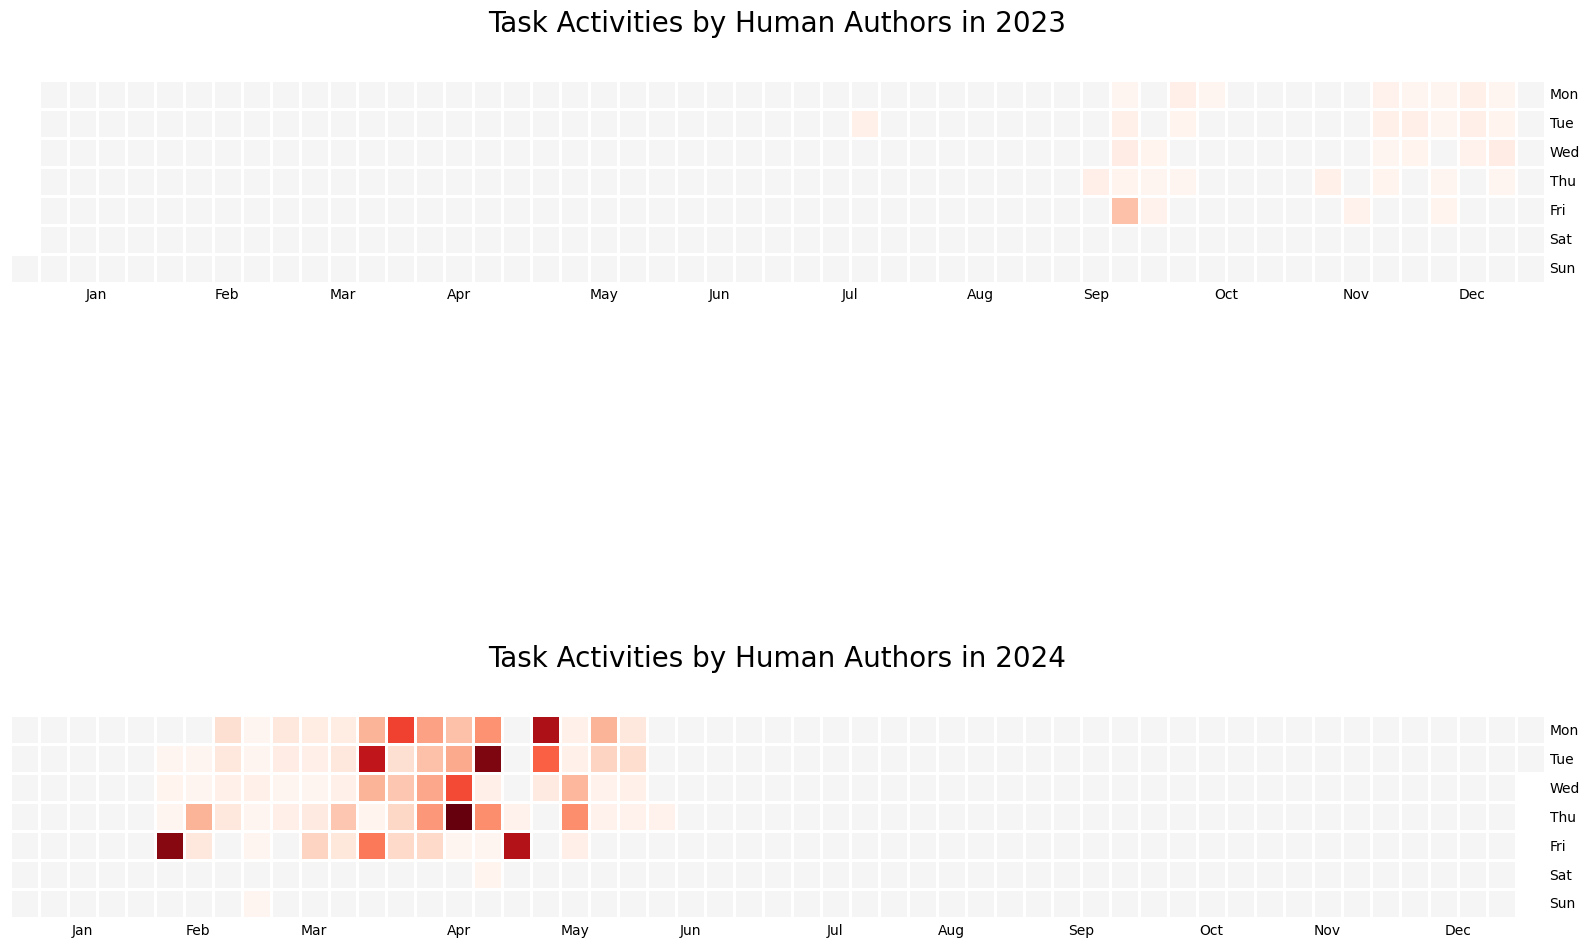

In [160]:
import pandas as pd
import numpy as np
import plotly.express as px

# Load your CSV file
df = auth_history_df

df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Filter out workflow-related activities
human_authors = [
    'Лавриненко Василий Александрович', 'Шогин Михаил Михайлович',
    'Ливенцев Сергей Викторович', 'Марчук Валентин', 'Григорьев Марк',
    'Вансевич Евгений Алексеевич', 'Крестенкова Виктория Александровна',
    'Артем Аниковский', 'Крупенко Илья Игоревич', 'Попова Анастасия Андреевна',
    'Диана Ливенцева', 'Евгений Александров', 'Виталий Гусельников',
    'Чаплинский Ярослав Эдуардович', 'Знаткова Мария Михайловна',
    'Эрик Садгалин', 'Дмитрий Чумак', 'Марков Кирилл Павлович',
    'Харапут Роман Сергеевич', 'София Захarova', 'Кudrявцев Роман Викторович',
    'Артем Королев', 'Зюванов Сергей Игоревич', 'Гиргвлиани Георгий Ростomovich',
    'Vladimir Storozhenko', 'Роман Васильев', 'Dmitry Budarin', 'Deleted User'
]

filtered_df = df[df['author_name'].isin(human_authors)]

# Create a new column for date without time
filtered_df['date'] = filtered_df['timestamp'].dt.date

# Group by date and count activities
activity_counts = filtered_df.groupby('date').size().reset_index(name='count')

# Prepare data for calmap
activity_counts_series = pd.Series(activity_counts['count'].values, index=pd.to_datetime(activity_counts['date']))

# Plot calendar heatmaps for all available years
years = activity_counts_series.index.year.unique()

fig, axes = plt.subplots(len(years), 1, figsize=(16, 8 * len(years)))
for i, year in enumerate(years):
    ax = axes[i] if len(years) > 1 else axes
    calmap.yearplot(activity_counts_series, year=year, ax=ax)
    ax.set_title(f'Task Activities by Human Authors in {year}', y=1.2, fontsize=20)

plt.tight_layout()
# plt.savefig('heatmap_calmap_all_years.png')
plt.show()

In [161]:
# Filter relevant columns
auth_details_filtered = auth_details_df[(auth_details_df['type'] == 'Task') & (auth_details_df['state'] == 'Done')][['issue_id', 'idReadable', 'created']]
auth_history_filtered = auth_history_df[auth_history_df['added_name'] == 'Done'][['issue_id', 'timestamp']]

# Find the latest 'Done' timestamp for each issue_id
latest_done_timestamps = auth_history_filtered.groupby('issue_id')['timestamp'].max().reset_index()

# Merge with auth_details to get the created timestamp
merged_df = pd.merge(auth_details_filtered, latest_done_timestamps, on='issue_id', how='left')

# Convert timestamps to datetime
merged_df['created'] = pd.to_datetime(merged_df['created'], unit='ms')
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'], unit='ms')

merged_df['lead_time_hours'] = (merged_df['timestamp'] - merged_df['created']).dt.total_seconds() / 3600

# Calculate the average lead time in hours
average_lead_time_hours = merged_df['lead_time_hours'].mean()

# Convert the average lead time to days
average_lead_time_days = average_lead_time_hours / 24


print("Average Lead Time in Hours:", average_lead_time_hours)
print("Average Lead Time in Days:", average_lead_time_days)

Average Lead Time in Hours: 779.8578927121913
Average Lead Time in Days: 32.49407886300797


In [111]:
merged_df

,issue_id,idReadable,created,timestamp,lead_time_days
0,92-1371665,VR-10651,2024-05-21 08:32:36.715,2024-05-23 08:24:33.673,1
1,92-1370615,VR-10645,2024-05-20 17:01:16.526,2024-05-21 12:02:05.355,0
2,92-1368484,VR-10627,2024-05-20 11:07:26.104,2024-05-20 17:12:09.433,0
3,92-1368001,VR-10622,2024-05-20 10:00:33.432,2024-05-20 11:07:56.696,0
4,92-1364131,VR-10590,2024-05-17 11:10:38.420,2024-05-20 19:54:36.376,3
...,...,...,...,...,...
67,92-884029,VR-5422,2023-09-19 05:01:10.518,2023-11-09 12:59:04.028,51
68,92-884028,VR-5421,2023-09-19 05:00:33.437,2024-04-04 08:08:10.752,198
69,92-884026,VR-5419,2023-09-19 04:59:01.938,2024-04-01 08:22:06.140,195
70,92-884025,VR-5418,2023-09-19 04:58:34.585,2024-03-19 12:49:23.952,182


In [114]:
history_df

,issue_id,timestamp,author_login,author_name,activity_type,added_type,added_name,removed_type,removed_name
0,92-1192150,2024-03-12 13:34:37.590,Valentin_Marchuk,Марчук Валентин,CommentActivityItem,IssueComment,None,None,None
1,92-1192150,2024-05-27 14:27:44.911,Valentin_Marchuk,Марчук Валентин,CustomFieldActivityItem,StateBundleElement,Blocked,None,None
3,92-1192150,2024-06-03 10:56:51.759,Valentin_Marchuk,Марчук Валентин,CustomFieldActivityItem,NoneType,None,None,None
6,92-1192150,2024-06-03 10:56:53.398,Valentin_Marchuk,Марчук Валентин,CustomFieldActivityItem,NoneType,None,None,None
12,92-1192150,2024-06-03 10:56:59.725,Valentin_Marchuk,Марчук Валентин,CustomFieldActivityItem,int,1719576000000,None,None
...,...,...,...,...,...,...,...,...,...
996150,92-669573,2023-01-23 12:00:16.618,Lavrinenko.V2,Лавриненко Василий Александрович,CustomFieldActivityItem,StateBundleElement,In Progress,None,None
996152,92-669573,2023-01-23 12:00:19.503,Lavrinenko.V2,Лавриненко Василий Александрович,CustomFieldActivityItem,StateBundleElement,Testing,None,None
996154,92-669573,2023-01-23 12:00:42.895,Lavrinenko.V2,Лавриненко Василий Александрович,CustomFieldActivityItem,StateBundleElement,Done,None,None
996156,92-669573,2023-05-29 06:40:34.720,custom_fields_user_425224596,JetBrains YouTrack,CustomFieldActivityItem,None,None,None,None


In [168]:
# history_df['timestamp'] = pd.to_datetime(history_df['timestamp'], unit='ms')

valid_task_ids = auth_details_df[(auth_details_df['type'] == 'Task') & (auth_details_df['state'] == 'Done')]['issue_id'].unique()


# Filter the data to get only rows with added_name related to the "Review" state
review_state_data = auth_history_df[(auth_history_df['added_name'] == 'Review') & (auth_history_df['issue_id'].isin(valid_task_ids))]

# Calculate the review durations for each task
review_durations = []

# Group by issue_id to handle each task separately
grouped = review_state_data.groupby('issue_id')

for issue_id, group in grouped:
    group = group.sort_values(by='timestamp')
    timestamps = group['timestamp'].tolist()
    
    # Calculate the review durations by pairing timestamps
    total_review_duration = 0
    for i in range(0, len(timestamps) - 1, 2):
        start_time = timestamps[i]
        end_time = timestamps[i + 1]
        duration = (end_time - start_time).total_seconds() / 3600  # Convert to hours
        total_review_duration += duration
    
    id_readable =  auth_details_df[auth_details_df['issue_id'] == issue_id].iloc[0]['idReadable']
    review_durations.append({
        'issue_id': issue_id,
        'id_readable': id_readable,
        'total_review_duration_hours': total_review_duration  # Numeric value in hours
    })

# Convert the results to a DataFrame
review_durations_df = pd.DataFrame(review_durations)



total_average_review_duration = review_durations_df[review_durations_df['total_review_duration_hours'] != 0]['total_review_duration_hours'].mean()

total_average_df = pd.DataFrame([{
    'total_average_review_duration_hours': total_average_review_duration
}])


total_average_review_duration

202.1247688271605

/var/folders/x2/0f74_mmn0ts5qbnsn_wp241w0000gn/T/ipykernel_7973/193071851.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/x2/0f74_mmn0ts5qbnsn_wp241w0000gn/T/ipykernel_7973/193071851.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



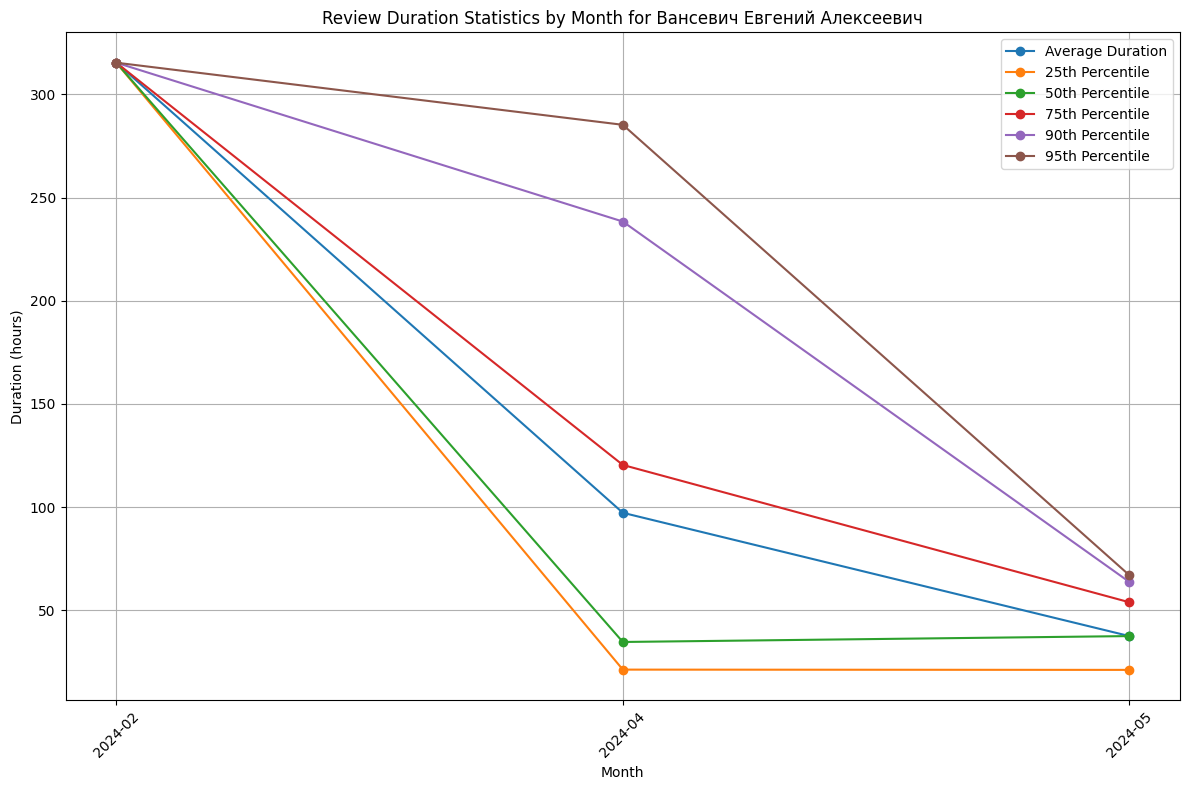

In [176]:
import pandas as pd
import matplotlib.pyplot as plt


# Convert timestamps to datetime
auth_history_df['timestamp'] = pd.to_datetime(auth_history_df['timestamp'], unit='ms')

# Filter the valid tasks
valid_task_ids = auth_details_df[(auth_details_df['type'] == 'Task') & (auth_details_df['state'] == 'Done')]['issue_id'].unique()

# Extract the month and year from the timestamp
auth_history_df['year_month'] = auth_history_df['timestamp'].dt.to_period('M')

# Merge review durations with the original history to get the timestamp
review_state_data = auth_history_df[(auth_history_df['added_name'] == 'Review') & (auth_history_df['issue_id'].isin(valid_task_ids))]

# Calculate the review durations with the month for each task
review_durations = []

grouped = review_state_data.groupby('issue_id')

for issue_id, group in grouped:
    group = group.sort_values(by='timestamp')
    timestamps = group['timestamp'].tolist()
    months = group['year_month'].tolist()
    
    for i in range(0, len(timestamps) - 1, 2):
        start_time = timestamps[i]
        end_time = timestamps[i + 1]
        duration = (end_time - start_time).total_seconds() / 3600  # Convert to hours
        month = months[i]
        review_durations.append({
            'issue_id': issue_id,
            'month': month,
            'duration': duration
        })

# Convert the results to a DataFrame
monthly_review_durations_df = pd.DataFrame(review_durations)

# Filter for the specific reviewer
reviewer_tasks = auth_details_df[auth_details_df['reviewer'] == 'Вансевич Евгений Алексеевич']['issue_id'].unique()
monthly_reviewer_review_durations = monthly_review_durations_df[monthly_review_durations_df['issue_id'].isin(reviewer_tasks)]

# Group by month and calculate the statistics
monthly_stats = monthly_reviewer_review_durations.groupby('month')['duration'].agg([
    'mean',
    lambda x: x.quantile(0.25),
    lambda x: x.quantile(0.5),
    lambda x: x.quantile(0.75),
    lambda x: x.quantile(0.90),
    lambda x: x.quantile(0.95)
]).rename(columns={
    'mean': 'average_duration',
    '<lambda_0>': '25th_percentile',
    '<lambda_1>': '50th_percentile',
    '<lambda_2>': '75th_percentile',
    '<lambda_3>': '90th_percentile',
    '<lambda_4>': '95th_percentile'
})

# Plotting the statistics
plt.figure(figsize=(12, 8))
plt.plot(monthly_stats.index.astype(str), monthly_stats['average_duration'], label='Average Duration', marker='o')
plt.plot(monthly_stats.index.astype(str), monthly_stats['25th_percentile'], label='25th Percentile', marker='o')
plt.plot(monthly_stats.index.astype(str), monthly_stats['50th_percentile'], label='50th Percentile', marker='o')
plt.plot(monthly_stats.index.astype(str), monthly_stats['75th_percentile'], label='75th Percentile', marker='o')
plt.plot(monthly_stats.index.astype(str), monthly_stats['90th_percentile'], label='90th Percentile', marker='o')
plt.plot(monthly_stats.index.astype(str), monthly_stats['95th_percentile'], label='95th Percentile', marker='o')

plt.xlabel('Month')
plt.ylabel('Duration (hours)')
plt.title('Review Duration Statistics by Month for Вансевич Евгений Алексеевич')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
review_durations_df

In [165]:
review_durations_df[review_durations_df['total_review_duration_hours'] != 0]

,issue_id,id_readable,total_review_duration_hours
4,92-1132076,VR-8412,150.127028
11,92-1225558,VR-9232,25.549142
15,92-1233244,VR-9330,45.860876
16,92-1233246,VR-9331,92.676443
20,92-1250145,VR-9523,144.602363
22,92-1263924,VR-9636,21.431859
23,92-1263936,VR-9637,21.179350
24,92-1270199,VR-9688,47.837216
27,92-1272980,VR-9710,332.096232
32,92-1285130,VR-9806,16.260055


In [170]:
auth_history_df['timestamp'] = pd.to_datetime(auth_history_df['timestamp'], unit='ms')

# Sort the data by timestamp to get comments from first to latest
sorted_data = auth_history_df.sort_values(by='timestamp')

# Extract comments (assuming comments are in a column named 'comments')
comments = sorted_data[['timestamp', 'author_name', 'activity_type', 'added_name', 'removed_name']]

/var/folders/x2/0f74_mmn0ts5qbnsn_wp241w0000gn/T/ipykernel_7973/2278993770.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [171]:
comments

,timestamp,author_name,activity_type,added_name,removed_name
866208,2023-07-18 15:05:15.703,Deleted User,CustomFieldActivityItem,User Story,None
866210,2023-07-18 15:05:23.259,Deleted User,CustomFieldActivityItem,Чаплинский Ярослав Эдуардович,None
866211,2023-07-18 15:05:25.723,Deleted User,CustomFieldActivityItem,Decomposition,None
866213,2023-07-18 15:05:29.410,Deleted User,CustomFieldActivityItem,Совсем не изян,None
866214,2023-07-18 18:02:41.854,JetBrains YouTrack,CustomFieldActivityItem,not_important,None
...,...,...,...,...,...
1905,2024-06-06 13:02:45.581,YouTrack Workflow,CustomFieldActivityItem,382980,None
93322,2024-06-06 13:02:45.581,YouTrack Workflow,CustomFieldActivityItem,9120,None
2046,2024-06-06 15:37:44.175,Шогин Михаил Михайлович,CustomFieldActivityItem,Шогин Михаил Михайлович,None
2023,2024-06-06 17:58:26.947,Марчук Валентин,CommentActivityItem,None,None


In [182]:
auth_history_df[auth_history_df['activity_type'] == 'CommentActivityItem']

,issue_id,timestamp,author_login,author_name,activity_type,added_type,added_name,removed_type,removed_name,year_month
2023,92-1424115,2024-06-06 17:58:26.947,Valentin_Marchuk,Марчук Валентин,CommentActivityItem,IssueComment,None,None,None,2024-06
14635,92-1335094,2024-05-07 11:00:57.376,Lavrinenko.V2,Лавриненко Василий Александрович,CommentActivityItem,IssueComment,None,None,None,2024-05
14636,92-1335094,2024-05-30 08:06:09.984,Lavrinenko.V2,Лавриненко Василий Александрович,CommentActivityItem,IssueComment,None,None,None,2024-05
16754,92-1368944,2024-05-20 12:15:14.193,Valentin_Marchuk,Марчук Валентин,CommentActivityItem,IssueComment,None,None,None,2024-05
16764,92-1368944,2024-05-21 15:07:19.503,krestenkova.v,Крестенкова Виктория Александровна,CommentActivityItem,IssueComment,None,None,None,2024-05
...,...,...,...,...,...,...,...,...,...,...
807410,92-884019,2023-09-28 05:26:54.562,Yaraslau_Chaplinski,Чаплинский Ярослав Эдуардович,CommentActivityItem,IssueComment,None,None,None,2023-09
807429,92-884019,2023-09-29 07:58:09.221,Yaraslau_Chaplinski,Чаплинский Ярослав Эдуардович,CommentActivityItem,IssueComment,None,None,None,2023-09
808868,92-884019,2024-02-19 21:53:44.623,Mikhail_Shogin,Шогин Михаил Михайлович,CommentActivityItem,IssueComment,None,None,None,2024-02
808899,92-884017,2023-09-20 15:24:12.133,Yaraslau_Chaplinski,Чаплинский Ярослав Эдуардович,CommentActivityItem,IssueComment,None,None,None,2023-09


In [177]:
auth_details_df

,issue_id,idReadable,updated,resolved,reporter_login,reporter_fullName,reporter_id,created,summary,description,assignee,Complexity,Devs,Environments,Impact,Importance,priority,Product,reviewer,Services,state,Status,Stream,type,Urgency
0,92-1424125,VR-11149,1717697342816,NaN,Valentin_Marchuk,Марчук Валентин,24-5060,1717697342816,[FE] Собирать метрики фейлов авторизации AuthV3,Нам нужно собирать метрики:\n\n\n\n* сколько л...,Лавриненко Василий Александрович,Семечки,FE,local,NaN,NaN,Show-stopper,NaN,Марчук Валентин,NaN,To Do,NaN,Product,Task,NaN
1,92-1424115,VR-11148,1717697343237,NaN,Valentin_Marchuk,Марчук Валентин,24-5060,1717696705992,[UserStory] AuthV3 авторизация. Сбор событий и...,## Проблема\n\nЕсли у человека нету активной м...,Марчук Валентин,Вроде не изян,NaN,local,NaN,NaN,Critical,NaN,NaN,NaN,In Progress,NaN,Support,User Story,NaN
228,92-1393585,VR-10905,1716985371341,1.716985e+12,zyuvanov.sergey,Зюванов Сергей Игоревич,24-6045,1716897681148,[BUG] Не подтягивается количество сотрудников ...,# Общее описание\n\nОкружение: `prod`\nУчётна...,Марков Кирилл Павлович,Семечки,BE,prod,NaN,NaN,Critical,NaN,Марков Кирилл Павлович,NaN,Done,NaN,Support,Bug,NaN
477,92-1371814,VR-10652,1716281526657,1.716281e+12,grigorev.mark,Григорьев Марк,24-4984,1716281485432,[BE] обновить Toolkit версию на стейдже,обновить Toolkit версию на стейдже до 0.0.24\n...,Григорьев Марк,NaN,BE,stage,NaN,NaN,Normal,NaN,Вансевич Евгений Алексеевич,NaN,Canceled,NaN,Product,Task,NaN
478,92-1371665,VR-10651,1716452673672,1.716453e+12,Valentin_Marchuk,Марчук Валентин,24-5060,1716280356715,[BE] Подготовить МРы для выкатки AuthV3 в прод,"Подготовить МРы для выкатки AuthV3 в прод, мры...",Вансевич Евгений Алексеевич,Семечки,BE,stage,NaN,NaN,Critical,NaN,Вансевич Евгений Алексеевич,NaN,Done,NaN,Product,Task,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21450,92-884020,VR-5413,1714721140487,1.711460e+12,Yaraslau_Chaplinski,Чаплинский Ярослав Эдуардович,24-3942,1695099249164,[BE] - AuthV3 - Интеграция auth v3 в adminka-api,# Проблема\n\nОбъявлено об обязательном перехо...,Чаплинский Ярослав Эдуардович,Вроде не изян,BE,local,NaN,NaN,Show-stopper,NaN,Шогин Михаил Михайлович,NaN,Canceled,NaN,Product,Task,NaN
21451,92-884019,VR-5412,1714993118775,1.708380e+12,Yaraslau_Chaplinski,Чаплинский Ярослав Эдуардович,24-3942,1695099208523,[BE] - AuthV3 - Написать middleware для аутент...,# Проблема\n\nОбъявлено об обязательном перехо...,Чаплинский Ярослав Эдуардович,Вроде не изян,BE,local,NaN,NaN,Show-stopper,NaN,Шогин Михаил Михайлович,NaN,Canceled,NaN,Product,Task,NaN
21452,92-884017,VR-5411,1714721500572,NaN,Yaraslau_Chaplinski,Чаплинский Ярослав Эдуардович,24-3942,1695099098425,[BE] - AuthV3 - Написать клиент для работы с a...,# Проблема\n\nОбъявлено об обязательном перехо...,Чаплинский Ярослав Эдуардович,Вроде не изян,BE,local,NaN,NaN,Show-stopper,NaN,Вансевич Евгений Алексеевич,NaN,Review,NaN,Product,Task,NaN
21488,92-878245,VR-5371,1714993132926,1.701123e+12,Yaraslau_Chaplinski,Чаплинский Ярослав Эдуардович,24-3942,1694671614211,[BE][ARCH] - AuthV3 - Архитектура и Декомпозиция,# Проблема\n\nОбъявлено об обязательном перехо...,Шогин Михаил Михайлович,Вроде не изян,BE,local,NaN,NaN,Show-stopper,NaN,Шогин Михаил Михайлович,NaN,Done,NaN,Product,Task,NaN


# Blocked state

In [189]:
history_df['timestamp_date'] = pd.to_datetime(history_df['timestamp'], unit='ms')

In [191]:
history_df[history_df['issue_id'] == '92-1286110']

,issue_id,timestamp,author_login,author_name,activity_type,added_type,added_name,removed_type,removed_name,timestamp_date
16876,92-1286110,1713253494004,Lavrinenko.V2,Лавриненко Василий Александрович,CustomFieldActivityItem,StateBundleElement,In Progress,None,None,2024-04-16 07:44:54.004
16878,92-1286110,1713253504704,Lavrinenko.V2,Лавриненко Василий Александрович,CustomFieldActivityItem,StateBundleElement,To Do,None,None,2024-04-16 07:45:04.704
16880,92-1286110,1713257426370,Lavrinenko.V2,Лавриненко Василий Александрович,CustomFieldActivityItem,StateBundleElement,In Progress,None,None,2024-04-16 08:50:26.370
16882,92-1286110,1713258070365,workflow_user_1224751877,YouTrack Workflow,CustomFieldActivityItem,int,60,None,None,2024-04-16 09:01:10.365
16884,92-1286110,1713261096334,Lavrinenko.V2,Лавриненко Василий Александрович,CustomFieldActivityItem,StateBundleElement,Blocked,None,None,2024-04-16 09:51:36.334
16886,92-1286110,1713261166840,Lavrinenko.V2,Лавриненко Василий Александрович,CommentActivityItem,IssueComment,None,None,None,2024-04-16 09:52:46.840
16887,92-1286110,1713341424366,Lavrinenko.V2,Лавриненко Василий Александрович,CustomFieldActivityItem,StateBundleElement,Done,None,None,2024-04-17 08:10:24.366
16889,92-1286110,1713341426330,Lavrinenko.V2,Лавриненко Василий Александрович,CustomFieldActivityItem,EnumBundleElement,stage,None,None,2024-04-17 08:10:26.330
16891,92-1286110,1713427295891,Lavrinenko.V2,Лавриненко Василий Александрович,CustomFieldActivityItem,EnumBundleElement,local,None,None,2024-04-18 08:01:35.891
16893,92-1286110,1713427708933,Lavrinenko.V2,Лавриненко Василий Александрович,CustomFieldActivityItem,StateBundleElement,Review,None,None,2024-04-18 08:08:28.933


In [190]:
history_df

,issue_id,timestamp,author_login,author_name,activity_type,added_type,added_name,removed_type,removed_name,timestamp_date
0,92-1192150,1710250477590,Valentin_Marchuk,Марчук Валентин,CommentActivityItem,IssueComment,None,None,None,2024-03-12 13:34:37.590
1,92-1192150,1716820064911,Valentin_Marchuk,Марчук Валентин,CustomFieldActivityItem,StateBundleElement,Blocked,None,None,2024-05-27 14:27:44.911
3,92-1192150,1717412211759,Valentin_Marchuk,Марчук Валентин,CustomFieldActivityItem,NoneType,None,None,None,2024-06-03 10:56:51.759
6,92-1192150,1717412213398,Valentin_Marchuk,Марчук Валентин,CustomFieldActivityItem,NoneType,None,None,None,2024-06-03 10:56:53.398
12,92-1192150,1717412219725,Valentin_Marchuk,Марчук Валентин,CustomFieldActivityItem,int,1719576000000,None,None,2024-06-03 10:56:59.725
...,...,...,...,...,...,...,...,...,...,...
996150,92-669573,1674475216618,Lavrinenko.V2,Лавриненко Василий Александрович,CustomFieldActivityItem,StateBundleElement,In Progress,None,None,2023-01-23 12:00:16.618
996152,92-669573,1674475219503,Lavrinenko.V2,Лавриненко Василий Александрович,CustomFieldActivityItem,StateBundleElement,Testing,None,None,2023-01-23 12:00:19.503
996154,92-669573,1674475242895,Lavrinenko.V2,Лавриненко Василий Александрович,CustomFieldActivityItem,StateBundleElement,Done,None,None,2023-01-23 12:00:42.895
996156,92-669573,1685342434720,custom_fields_user_425224596,JetBrains YouTrack,CustomFieldActivityItem,None,None,None,None,2023-05-29 06:40:34.720


In [195]:
data = history_df

# Filter out activities by 'workflow_user_1224751877'
filtered_data = data[data['author_login'] != 'workflow_user_1224751877']

# Convert the timestamp to datetime for chronological operations
filtered_data['timestamp'] = pd.to_datetime(filtered_data['timestamp'], unit='ms')

# Sort data by issue_id and timestamp to ensure chronological order
filtered_data = filtered_data.sort_values(by=['issue_id', 'timestamp'])

# Identify when a task is moved to the "Blocked" state
blocked_state = filtered_data[
    (filtered_data['activity_type'] == 'CustomFieldActivityItem') &
    (filtered_data['added_name'] == 'Blocked')
]

# Initialize counters for positive and negative cases
positive_cases = 0
negative_cases = 0

# Process each blocked state entry
for index, row in blocked_state.iterrows():
    issue_id = row['issue_id']
    user = row['author_login']
    block_time = row['timestamp']

    # Filter activities for the same issue after the block time
    subsequent_activities = filtered_data[
        (filtered_data['issue_id'] == issue_id) &
        (filtered_data['timestamp'] > block_time)
    ]

    # Check for a comment by the same user who blocked the task
    comment_by_user = subsequent_activities[
        (subsequent_activities['author_login'] == user) &
        (subsequent_activities['activity_type'] == 'CommentActivityItem')
    ]

    if not comment_by_user.empty:
        positive_cases += 1
    else:
        negative_cases += 1

# Summary report
summary = {
    'Positive Cases': positive_cases,
    'Negative Cases': negative_cases
}

summary

/var/folders/x2/0f74_mmn0ts5qbnsn_wp241w0000gn/T/ipykernel_7973/1074380984.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



{'Positive Cases': 1196, 'Negative Cases': 1478}

/var/folders/x2/0f74_mmn0ts5qbnsn_wp241w0000gn/T/ipykernel_7973/2251839181.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



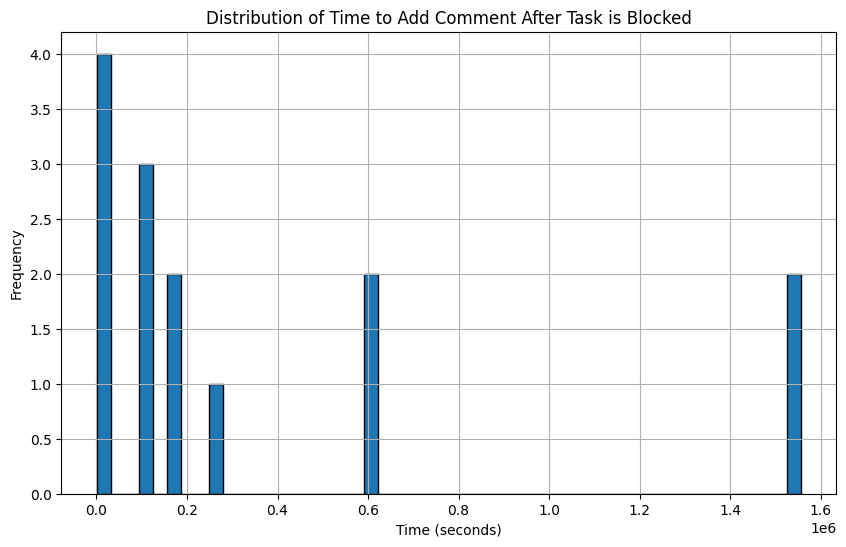

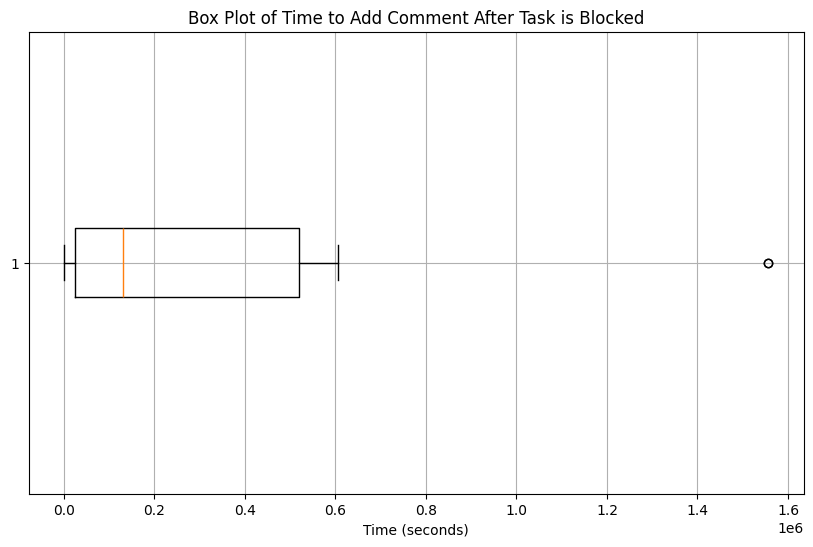

In [207]:
# Filter out activities performed by 'workflow_user_1224751877'
# filtered_data = data[data['author_login'] != 'workflow_user_1224751877']

filtered_data = data[data['author_name'].isin(get_names_by_position('DevOps'))]

# Convert the timestamp to datetime for chronological operations
filtered_data['timestamp'] = pd.to_datetime(filtered_data['timestamp'], unit='ms')

# Sort data by issue_id and timestamp to ensure chronological order
filtered_data = filtered_data.sort_values(by=['issue_id', 'timestamp'])

# Identify when a task is moved to the "Blocked" state
blocked_state = filtered_data[
    (filtered_data['activity_type'] == 'CustomFieldActivityItem') &
    (filtered_data['added_name'] == 'Blocked')
]

# List to store time differences for positive cases
time_differences = []

# Process each blocked state entry to calculate time to add comment
for index, row in blocked_state.iterrows():
    issue_id = row['issue_id']
    user = row['author_login']
    block_time = row['timestamp']

    # Filter activities for the same issue after the block time
    subsequent_activities = filtered_data[
        (filtered_data['issue_id'] == issue_id) &
        (filtered_data['timestamp'] > block_time)
    ]

    # Check for a comment by the same user who blocked the task
    comment_by_user = subsequent_activities[
        (subsequent_activities['author_login'] == user) &
        (subsequent_activities['activity_type'] == 'CommentActivityItem')
    ]

    if not comment_by_user.empty:
        # Calculate the time difference to the first comment by the same user
        first_comment_time = comment_by_user.iloc[0]['timestamp']
        time_difference = (first_comment_time - block_time).total_seconds()
        time_differences.append(time_difference)

# Analyze the data
mean_time = pd.Series(time_differences).mean()
median_time = pd.Series(time_differences).median()
std_dev_time = pd.Series(time_differences).std()

# Summary report
time_analysis_summary = {
    'Mean Time (seconds)': mean_time,
    'Median Time (seconds)': median_time,
    'Standard Deviation (seconds)': std_dev_time,
    'Total Positive Cases Analyzed': len(time_differences)
}

# Display the summary
# Create visualizations
import matplotlib.pyplot as plt

# Histogram
plt.figure(figsize=(10, 6))
plt.hist(time_differences, bins=50, edgecolor='black')
plt.title('Distribution of Time to Add Comment After Task is Blocked')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Box Plot
plt.figure(figsize=(10, 6))
plt.boxplot(time_differences, vert=False)
plt.title('Box Plot of Time to Add Comment After Task is Blocked')
plt.xlabel('Time (seconds)')
plt.grid(True)
plt.show()

Mean Time (hours): 244.53
Median Time (hours): 18.98
Standard Deviation (hours): 476.38
Total Positive Cases Analyzed: 151
25th Percentile (hours): 0.02
50th Percentile (hours): 18.98
75th Percentile (hours): 216.27
95th Percentile (hours): 1462.02
99th Percentile (hours): 1900.36
Mean Time (hours): 78.02
Median Time (hours): 0.40
Standard Deviation (hours): 241.24
Total Positive Cases Analyzed: 101
25th Percentile (hours): 0.02
50th Percentile (hours): 0.40
75th Percentile (hours): 60.10
95th Percentile (hours): 239.54
99th Percentile (hours): 1392.61
Mean Time (hours): 48.44
Median Time (hours): 26.64
Standard Deviation (hours): 60.32
Total Positive Cases Analyzed: 12
25th Percentile (hours): 0.03
50th Percentile (hours): 26.64
75th Percentile (hours): 52.95
95th Percentile (hours): 167.99
99th Percentile (hours): 168.13


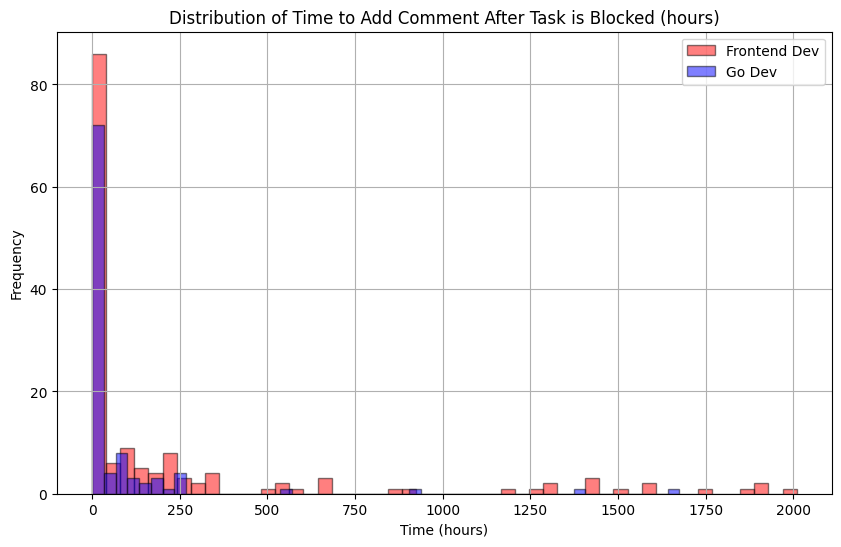

/var/folders/x2/0f74_mmn0ts5qbnsn_wp241w0000gn/T/ipykernel_7973/16769262.py:143: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



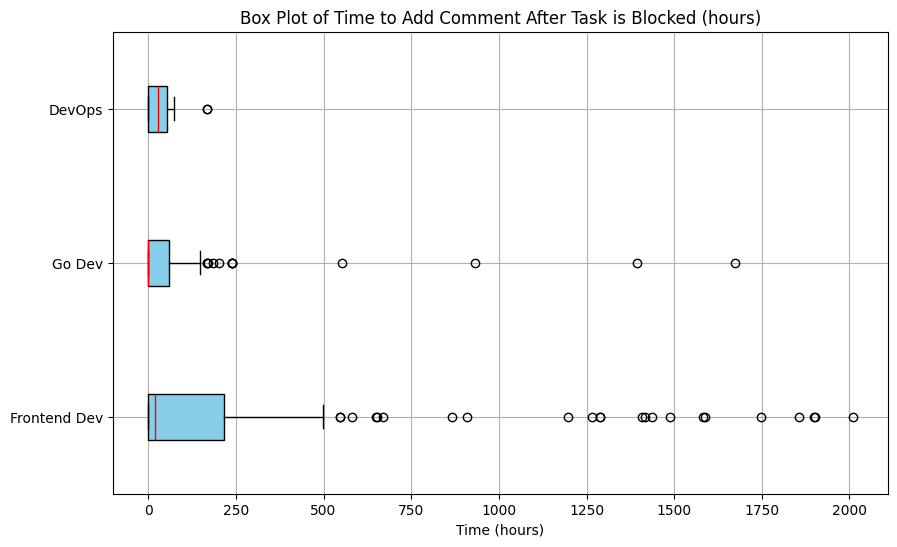

In [238]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime


def convert_to_textual_format(summary):
    lines = []
    for key, value in summary.items():
        if isinstance(value, float):
            lines.append(f'{key}: {value:.2f}')
        else:
            lines.append(f'{key}: {value}')
    return '\n'.join(lines)

def analyze_time_to_comment(data, time_unit='seconds', start_date=None):
    # Filter out activities performed by 'workflow_user_1224751877'
    filtered_data = data[data['author_login'] != 'workflow_user_1224751877']

    # Convert the timestamp to datetime for chronological operations
    filtered_data['timestamp'] = pd.to_datetime(filtered_data['timestamp'], unit='ms')

    # Filter data based on the specified start date
    if start_date:
        start_date = pd.to_datetime(start_date)
        filtered_data = filtered_data[filtered_data['timestamp'] >= start_date]

    # Sort data by issue_id and timestamp to ensure chronological order
    filtered_data = filtered_data.sort_values(by=['issue_id', 'timestamp'])

    # Identify when a task is moved to the "Blocked" state
    blocked_state = filtered_data[
        (filtered_data['activity_type'] == 'CustomFieldActivityItem') &
        (filtered_data['added_name'] == 'Blocked')
    ]

    # List to store time differences for positive cases
    time_differences = []

    # Process each blocked state entry to calculate time to add comment
    for index, row in blocked_state.iterrows():
        issue_id = row['issue_id']
        user = row['author_login']
        block_time = row['timestamp']

        # Filter activities for the same issue after the block time
        subsequent_activities = filtered_data[
            (filtered_data['issue_id'] == issue_id) &
            (filtered_data['timestamp'] > block_time)
        ]

        # Check for a comment by the same user who blocked the task
        comment_by_user = subsequent_activities[
            (subsequent_activities['author_login'] == user) &
            (subsequent_activities['activity_type'] == 'CommentActivityItem')
        ]

        if not comment_by_user.empty:
            # Calculate the time difference to the first comment by the same user
            first_comment_time = comment_by_user.iloc[0]['timestamp']
            time_difference = (first_comment_time - block_time).total_seconds()
            time_differences.append(time_difference)

    # Dictionary to convert time unit
    time_conversion = {
        'seconds': 1,
        'minutes': 60,
        'hours': 3600
    }
    
    # Convert time differences to the specified unit
    converted_time_differences = [td / time_conversion[time_unit] for td in time_differences]
    
    # Analyze the data
    mean_time = pd.Series(converted_time_differences).mean()
    median_time = pd.Series(converted_time_differences).median()
    std_dev_time = pd.Series(converted_time_differences).std()
    quantiles = pd.Series(converted_time_differences).quantile([0.25, 0.5, 0.75, 0.95, 0.99])
    
    # Summary report
    time_analysis_summary = {
        f'Mean Time ({time_unit})': mean_time,
        f'Median Time ({time_unit})': median_time,
        f'Standard Deviation ({time_unit})': std_dev_time,
        'Total Positive Cases Analyzed': len(time_differences),
        f'25th Percentile ({time_unit})': quantiles[0.25],
        f'50th Percentile ({time_unit})': quantiles[0.5],
        f'75th Percentile ({time_unit})': quantiles[0.75],
        f'95th Percentile ({time_unit})': quantiles[0.95],
        f'99th Percentile ({time_unit})': quantiles[0.99]
    }

    print(convert_to_textual_format(time_analysis_summary))

    return time_analysis_summary, converted_time_differences
   
    # Create visualizations
    # plt.figure(figsize=(10, 6))
    # plt.hist(converted_time_differences, bins=50, edgecolor='black')
    # plt.title(f'Distribution of Time to Add Comment After Task is Blocked ({time_unit})')
    # plt.xlabel(f'Time ({time_unit})')
    # plt.ylabel('Frequency')
    # plt.grid(True)
    # plt.show()

    # plt.figure(figsize=(10, 6))
    # plt.boxplot(converted_time_differences, vert=False)
    # plt.title(f'Box Plot of Time to Add Comment After Task is Blocked ({time_unit})')
    # plt.xlabel(f'Time ({time_unit})')
    # plt.grid(True)
    # plt.show()


frontend_data = history_df[history_df['author_name'].isin(get_names_by_position('Frontend Dev'))]
go_dev_data = history_df[history_df['author_name'].isin(get_names_by_position('Go Dev'))]
devops_data = history_df[history_df['author_name'].isin(get_names_by_position('DevOps'))]

# Run the analysis for each segment
summary_frontend, time_differences_frontend = analyze_time_to_comment(frontend_data, 'hours', start_date='2024-01-01')
summary_go_dev, time_differences_go_dev = analyze_time_to_comment(go_dev_data, 'hours', start_date='2024-01-01')
summary_devops, time_differences_devops = analyze_time_to_comment(devops_data, 'hours', start_date='2024-01-01')

# Print summaries
# print(summary_frontend)
# print(summary_go_dev)
# print(summary_devops)


# Create histograms with legends
plt.figure(figsize=(10, 6))
plt.hist(time_differences_frontend, bins=50, alpha=0.5, label='Frontend Dev', color='red', edgecolor='black')
plt.hist(time_differences_go_dev, bins=50, alpha=0.5, label='Go Dev', color='blue', edgecolor='black')
# plt.hist(time_differences_devops, bins=50, alpha=0.5, label='DevOps', color='green', edgecolor='black')

plt.title('Distribution of Time to Add Comment After Task is Blocked (hours)')
plt.xlabel('Time (hours)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Create box plots with legends
plt.figure(figsize=(10, 6))
plt.boxplot([time_differences_frontend, time_differences_go_dev, time_differences_devops], vert=False, patch_artist=True, 
            labels=['Frontend Dev', 'Go Dev', 'DevOps'],
            boxprops=dict(facecolor='skyblue', color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            medianprops=dict(color='red'))

plt.title('Box Plot of Time to Add Comment After Task is Blocked (hours)')
plt.xlabel('Time (hours)')
plt.grid(True)
plt.show()

Mean Time (hours): 55.43
Median Time (hours): 0.21
Standard Deviation (hours): 144.00
Total Positive Cases Analyzed: 52
25th Percentile (hours): 0.02
50th Percentile (hours): 0.21
75th Percentile (hours): 30.30
95th Percentile (hours): 239.37
99th Percentile (hours): 579.25


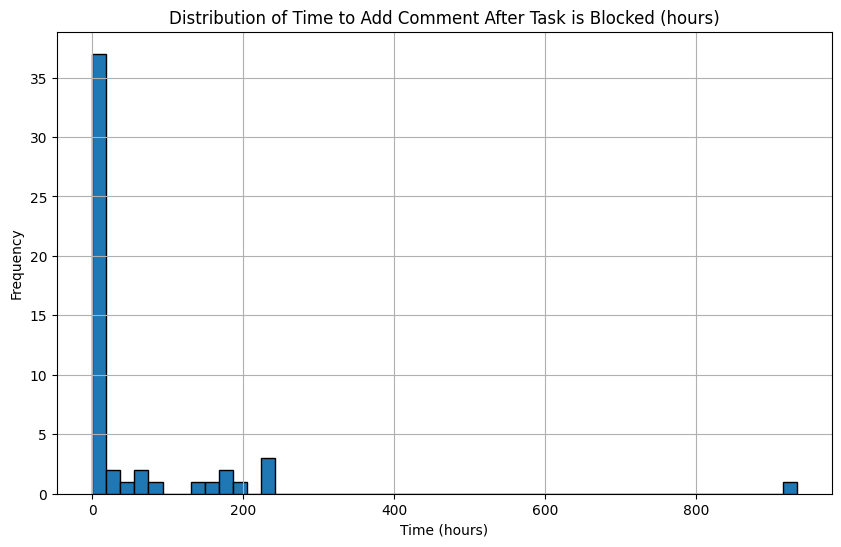

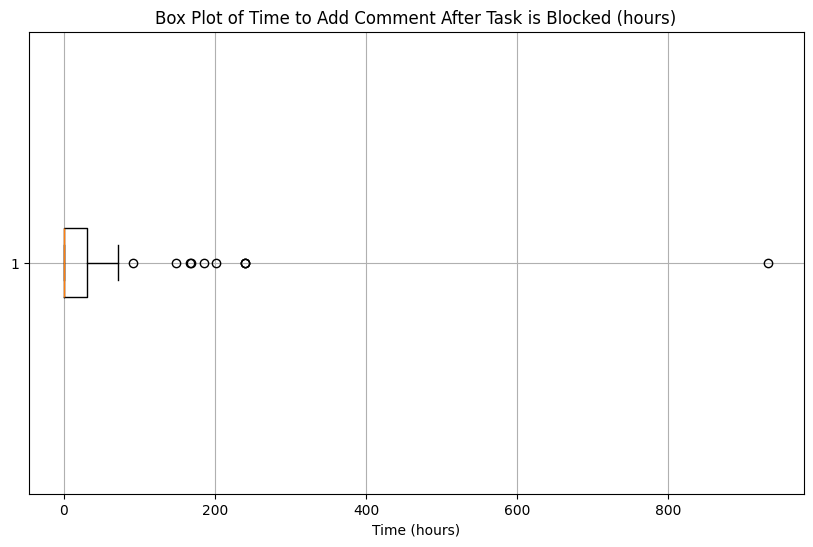

In [227]:
data = history_df[history_df['author_name'].isin(get_names_by_position('Go Dev'))]
# data = history_df

analyze_time_to_comment(data, 'hours', start_date='2024-04-01')

In [199]:
filtered_data = data[data['author_login'] == 'Нурбек Мустафетов']


filtered_data

,issue_id,timestamp,author_login,author_name,activity_type,added_type,added_name,removed_type,removed_name,timestamp_date


In [202]:
history_df[history_df['author_name'] == 'Нурбек Мустафетов']

,issue_id,timestamp,author_login,author_name,activity_type,added_type,added_name,removed_type,removed_name,timestamp_date
1951,92-1396382,2024-05-30 10:43:53.884,mustafetov.n,Нурбек Мустафетов,CommentActivityItem,IssueComment,None,None,None,2024-05-30 10:43:53.884
5328,92-1398484,2024-06-04 06:31:10.340,mustafetov.n,Нурбек Мустафетов,CustomFieldActivityItem,StateBundleElement,In Progress,None,None,2024-06-04 06:31:10.340
5330,92-1398484,2024-06-04 06:31:18.541,mustafetov.n,Нурбек Мустафетов,CustomFieldActivityItem,StateBundleElement,To Do,None,None,2024-06-04 06:31:18.541
5332,92-1398484,2024-06-05 08:25:43.403,mustafetov.n,Нурбек Мустафетов,CustomFieldActivityItem,StateBundleElement,Blocked,None,None,2024-06-05 08:25:43.403
5340,92-1411694,2024-06-04 06:31:12.033,mustafetov.n,Нурбек Мустафетов,CustomFieldActivityItem,StateBundleElement,In Progress,None,None,2024-06-04 06:31:12.033
...,...,...,...,...,...,...,...,...,...,...
508304,92-1236101,2024-04-04 08:00:43.642,mustafetov.n,Нурбек Мустафетов,CustomFieldActivityItem,StateBundleElement,In Progress,None,None,2024-04-04 08:00:43.642
508662,92-1236101,2024-05-06 09:41:39.974,mustafetov.n,Нурбек Мустафетов,CustomFieldActivityItem,StateBundleElement,To Do,None,None,2024-05-06 09:41:39.974
508679,92-1236101,2024-05-21 14:09:01.877,mustafetov.n,Нурбек Мустафетов,CommentActivityItem,IssueComment,None,None,None,2024-05-21 14:09:01.877
508680,92-1236101,2024-05-29 10:13:06.639,mustafetov.n,Нурбек Мустафетов,CommentActivityItem,IssueComment,None,None,None,2024-05-29 10:13:06.639


In [205]:
import pandas as pd

# Load the JSON data
empl_df = pd.read_json('./datasets/employees.json')

# Function to get list of names by position
def get_names_by_position(position):
    # Filter the DataFrame by the given position
    filtered_df = empl_df[empl_df['position'] == position]
    # Extract the full names as a list
    names_list = filtered_df['full_name'].tolist()
    return names_list

# Example usage
position_name = 'DevOps'
names = get_names_by_position(position_name)
print(names)

['Нурбек Мустафетов']


In [211]:
empl_df

,full_name,email,groups,position
0,Кудрявцев Роман Викторович,kudryavtsev@wb.ru,"[C&B, Registered Users]",Go Dev
1,Калинов Егор Юрьевич,kalinov.egor@wb.ru,"[Portal, Registered Users]",Frontend Dev
2,Петрова Любовь Владимировна,petrova.lyubov3@wb.ru,"[Portal, Registered Users]",None
3,Дурнов Сергей Юрьевич,durnov.sergey@wb.ru,"[Portal, Registered Users]",Frontend Dev
4,Лавриненко Василий Александрович,lavrinenko.v2@wb.ru,"[C&B, Registered Users]",Frontend Dev
...,...,...,...,...
71,Анастасия Дерябкина,deryabkina.a@wb.ru,"[ATS, Registered Users]",None
72,Эльвина Шамсутдинова,shamsutdinova.e6@wb.ru,"[C&B, Registered Users]",None
73,Иван Лисичкин,lisichkin.ivan2@wb.ru,"[WBTeam, Registered Users]",None
74,Александра Елизарова,elizarova.a13@wb.ru,"[HRTech, Registered Users]",None
